<a href="https://colab.research.google.com/github/NishatVasker/Machine_learning_projects/blob/main/Project_PERM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# ==========================================
# RUN ONCE (TOP OF NOTEBOOK):
# - Mount Google Drive
# - Set project paths
# - Global checkpoint system (your code)
# - Helpers: save_artifact + load_latest_checkpoint
# ==========================================

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, joblib, numpy as np, pandas as pd
from datetime import datetime

# -----------------------------
# PROJECT PATHS
# -----------------------------
BASE_DIR = "/content/drive/MyDrive/PERM_Project"
DATA_DIR = os.path.join(BASE_DIR, "data")
OUT_DIR  = os.path.join(BASE_DIR, "outputs")

os.makedirs(BASE_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUT_DIR,  exist_ok=True)

print("✅ BASE_DIR:", BASE_DIR)
print("✅ DATA_DIR:", DATA_DIR)
print("✅ OUT_DIR :", OUT_DIR)

# -----------------------------
# DATASET PATH (EDIT THIS ONCE)
# Put your file inside: MyDrive/PERM_Project/data/
# Example: PERM_Fixed.csv
# -----------------------------
DATA_FILE = os.path.join(DATA_DIR, "PERM_Fixed.csv")  # <-- change filename if different
print("📌 DATA_FILE:", DATA_FILE)

# ==========================================
# GLOBAL AUTO-CHECKPOINT SYSTEM (RUN ONCE)
# ==========================================
def checkpoint(section_name, **objects):
    """
    Save any objects with ONE line.
    """
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    sec_dir = os.path.join(BASE_DIR, f"{section_name}_{ts}")
    os.makedirs(sec_dir, exist_ok=True)

    for name, obj in objects.items():
        path = os.path.join(sec_dir, name)
        if isinstance(obj, np.ndarray):
            np.save(path + ".npy", obj)
        elif isinstance(obj, (pd.DataFrame, pd.Series)):
            obj.to_csv(path + ".csv", index=False)
        else:
            joblib.dump(obj, path + ".joblib")

    print(f"✅ Checkpoint saved: {sec_dir}")
    return sec_dir

# -----------------------------
# Helper: Save plots/tables/text easily
# -----------------------------
def save_artifact(filename: str) -> str:
    """
    Returns a safe path inside outputs/ for saving images/csv/etc.
    Example: plt.savefig(save_artifact("plot.png"))
    """
    return os.path.join(OUT_DIR, filename)

# -----------------------------
# Helper: Load latest checkpoint folder for a section
# -----------------------------
def load_latest_checkpoint(prefix: str) -> str:
    """
    Finds the newest checkpoint folder whose name starts with prefix.
    Example: latest = load_latest_checkpoint("section_7_final")
    """
    candidates = [d for d in os.listdir(BASE_DIR) if d.startswith(prefix + "_")]
    if not candidates:
        raise FileNotFoundError(f"No checkpoints found for prefix: {prefix}")
    candidates.sort()  # timestamp in name makes lexical sort work
    latest = os.path.join(BASE_DIR, candidates[-1])
    print("✅ Latest checkpoint:", latest)
    return latest

print("\n✅ RUN-ONCE SETUP COMPLETE.")
print("Next: run Section 1 (dataset load + status/target mapping).")


Mounted at /content/drive
✅ BASE_DIR: /content/drive/MyDrive/PERM_Project
✅ DATA_DIR: /content/drive/MyDrive/PERM_Project/data
✅ OUT_DIR : /content/drive/MyDrive/PERM_Project/outputs
📌 DATA_FILE: /content/drive/MyDrive/PERM_Project/data/PERM_Fixed.csv

✅ RUN-ONCE SETUP COMPLETE.
Next: run Section 1 (dataset load + status/target mapping).


In [19]:
# ==========================================
# COMPLETE: AUTO-FIND + LOAD + CEILING CHECK (PERM)
# ==========================================

# 0) Mount Drive
from google.colab import drive
drive.mount('/content/drive')

import os, re, warnings
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import balanced_accuracy_score, make_scorer

import xgboost as xgb
warnings.filterwarnings("ignore")

# =========================================================
# 1) AUTO-FIND YOUR CSV IN GOOGLE DRIVE
# =========================================================
# ✅ Update this keyword to match part of your filename.
# Examples: "PERM", "Fixed", "perm_fixed"
CSV_KEYWORD = "PERM"   # <-- change only if needed

ROOT = "/content/drive/MyDrive"

csv_paths = []
for dirpath, dirnames, filenames in os.walk(ROOT):
    for fn in filenames:
        if fn.lower().endswith(".csv") and CSV_KEYWORD.lower() in fn.lower():
            csv_paths.append(os.path.join(dirpath, fn))

if len(csv_paths) == 0:
    raise FileNotFoundError(
        f"❌ No CSV found containing keyword '{CSV_KEYWORD}' in MyDrive.\n"
        f"Try changing CSV_KEYWORD or ensure the CSV is in Google Drive."
    )

# Choose the largest matching CSV (usually your main dataset)
csv_paths_sorted = sorted(csv_paths, key=lambda p: os.path.getsize(p), reverse=True)
file_name = csv_paths_sorted[0]

print("✅ Found CSV candidates:")
for p in csv_paths_sorted[:10]:
    print(" -", p)
print("\n✅ Using this file:", file_name)

# Load
df = pd.read_csv(file_name, low_memory=False)
print("✅ Loaded dataset:", df.shape)

# =========================================================
# 2) FIND STATUS COLUMN + CREATE TARGET
# =========================================================
def find_col(cols, options):
    m = {c.lower(): c for c in cols}
    for o in options:
        if o.lower() in m:
            return m[o.lower()]
    return None

status_col = find_col(df.columns, ["CASE_STATUS", "STATUS", "CASE STATUS"])
if status_col is None:
    print("❌ Could not auto-find status column.")
    print("First 80 columns:", list(df.columns[:80]))
    raise ValueError("No CASE_STATUS/STATUS column found. Check your dataset columns.")

df[status_col] = df[status_col].astype(str).str.upper().str.strip()
df[status_col] = df[status_col].str.replace(r"\s+", " ", regex=True)
df[status_col] = df[status_col].str.replace(" - ", "-", regex=False)

keep_statuses = ["CERTIFIED", "DENIED", "CERTIFIED-EXPIRED"]
keep = df[df[status_col].isin(keep_statuses)].copy()
keep["target"] = (keep[status_col] != "DENIED").astype(int)

if keep.shape[0] == 0:
    print("❌ After filtering statuses, no rows remain.")
    print("Unique status values:", df[status_col].value_counts().head(25))
    raise ValueError("Status mapping mismatch. Adjust keep_statuses to match your file.")

class_balance = keep["target"].value_counts(normalize=True).to_dict()
baseline = max(class_balance.values())

print("\n📌 Status column:", status_col)
print("📌 Class balance:", class_balance)
print(f"📌 Majority baseline accuracy: {baseline:.4f} ({baseline*100:.2f}%)")
print("✅ Rows retained:", keep.shape)

# =========================================================
# 3) DROP LEAKAGE / IDENTITY
# =========================================================
drop_exact = {
    status_col,
    "CASE_NUMBER", "DECISION_DATE", "RECEIVED_DATE",
    "EMPLOYER_NAME", "EMPLOYER", "EMP_FEIN", "ATTY_AG_FEIN",
}

drop_patterns = [
    r".*EMAIL.*", r".*PHONE.*",
    r".*ADDR.*", r".*ADDRESS.*",
    r".*FIRST.*NAME.*", r".*LAST.*NAME.*", r".*MIDDLE.*NAME.*",
    r".*CONTACT.*", r".*FEIN.*", r".*BAR.*NUMBER.*",
    r".*P_O_C_.*", r".*POC.*",
    r".*ATTY.*NAME.*", r".*ATTORNEY.*",
]

to_drop = set()
drop_exact_upper = {c.upper() for c in drop_exact}

for c in keep.columns:
    cu = c.upper()
    if cu in drop_exact_upper:
        to_drop.add(c)
        continue
    for pat in drop_patterns:
        if re.match(pat, cu):
            to_drop.add(c)
            break

keep = keep.drop(columns=list(to_drop), errors="ignore")
print("✅ Dropped identity/leakage columns:", len(to_drop))

# =========================================================
# 4) FEATURE ALLOW-LIST (WORKFORCE/REGULATORY RELEVANT)
# =========================================================
ALLOW = [
    "JOB_TITLE", "OCCUPATION_TYPE", "SOC_CODE", "PWD_SOC_CODE", "PWD_SOC_TITLE",
    "PRIMARY_WORKSITE_STATE", "PRIMARY_WORKSITE_COUNTY", "PRIMARY_WORKSITE_BLS_AREA", "IS_MULTIPLE_LOCATIONS",
    "JOB_OPP_WAGE_FROM", "JOB_OPP_WAGE_TO", "JOB_OPP_WAGE_PER",
    "PW_WAGE", "PW_AMOUNT", "PREVAILING_WAGE",
    "EMP_NAICS", "EMP_NUM_PAYROLL", "EMP_YEAR_COMMENCED",
    "FOREIGN_WORKER_EDUCATION", "FOREIGN_WORKER_INFO_EDUCATION",
    "MINIMUM_EDUCATION", "REQUIRED_EDUCATION",
    "EMP_RELATIONSHIP_WORKER", "EMP_WORKER_INTEREST",
]

col_map = {c.lower(): c for c in keep.columns}
features = [col_map[a.lower()] for a in ALLOW if a.lower() in col_map]

if len(features) < 6:
    print("⚠️ Too few allow-list features found. Falling back to all non-target columns (still safe).")
    features = [c for c in keep.columns if c != "target"]

X = keep[features].copy()
y = keep["target"].astype(int).copy()

print("✅ Features used:", len(features))
print("✅ X shape:", X.shape)

# =========================================================
# 5) PIPELINE (NO LEAKAGE: preprocess inside CV)
# =========================================================
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ],
    remainder="drop"
)

clf = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    tree_method="hist",
    eval_metric="logloss",
    random_state=42,
    n_jobs=1
)

pipe = Pipeline([("prep", preprocess), ("clf", clf)])

# =========================================================
# 6) CEILING CHECK (5-fold Stratified CV, COLAB-SAFE)
# =========================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy", n_jobs=1)
bal = cross_val_score(pipe, X, y, cv=cv,
                      scoring=make_scorer(balanced_accuracy_score), n_jobs=1)

print("\n" + "="*70)
print("📊 PERM CEILING CHECK (Leakage-safe, 5-fold Stratified CV)")
print("="*70)
print("Accuracy per fold:", acc)
print(f"MEAN ACCURACY: {acc.mean():.4f} ({acc.mean()*100:.2f}%)")
print(f"CV ACCURACY STD: {acc.std():.4f}")
print("Balanced acc per fold:", bal)
print(f"MEAN BALANCED ACC: {bal.mean():.4f}")
print(f"BASELINE ACC: {baseline:.4f} ({baseline*100:.2f}%)")
print(f"LIFT OVER BASELINE: {(acc.mean()-baseline):.4f} ({(acc.mean()-baseline)*100:.2f}%)")
print("="*70)

if acc.mean() >= 0.90:
    print("✅ PASS — meets ≥90% accuracy with reviewer-safe pipeline")
else:
    print("❌ FAIL — below 90% (stop or redesign)")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Found CSV candidates:
 - /content/drive/MyDrive/PERM_Project/PERM_Fixed.csv.csv
 - /content/drive/MyDrive/PERM_Project/CHECKPOINTS/CORE_20260107_225549/PERM_CLEAN.csv
 - /content/drive/MyDrive/PERM_Project/SECTION_8_XAI_EXPORT/xai_permshap_raw_top.csv
 - /content/drive/MyDrive/PERM_Project/EXPORTS/xai_permshap_raw_top.csv
 - /content/drive/MyDrive/PERM_Project/SECTION_8_XAI_EXPORT/xai_permshap_grouped_mean_abs.csv
 - /content/drive/MyDrive/PERM_Project/EXPORTS/xai_permshap_grouped_mean_abs.csv

✅ Using this file: /content/drive/MyDrive/PERM_Project/PERM_Fixed.csv.csv
✅ Loaded dataset: (147056, 137)

📌 Status column: CASE_STATUS
📌 Class balance: {1: 0.981370397811467, 0: 0.018629602188533}
📌 Majority baseline accuracy: 0.9814 (98.14%)
✅ Rows retained: (140368, 138)
✅ Dropped identity/leakage columns: 41
✅ Features used: 16
✅ X shape: (140368, 16)

📊 PERM CEI

In [20]:
# ==========================================
# SECTION 1: ROBUST LOAD + STATUS INSPECTION
# ==========================================

import os
import pandas as pd
import numpy as np

# --------------------------------------------------
# 0) Mount Google Drive (safe to run multiple times)
# --------------------------------------------------
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass

# --------------------------------------------------
# 1) AUTO-FIND THE CSV (no hardcoded path)
# --------------------------------------------------
CSV_KEYWORD = "PERM"   # change ONLY if filename is very different

SEARCH_ROOTS = [
    "/content",
    "/content/drive/MyDrive"
]

csv_candidates = []

for root in SEARCH_ROOTS:
    if os.path.exists(root):
        for dirpath, _, filenames in os.walk(root):
            for fn in filenames:
                if fn.lower().endswith(".csv") and CSV_KEYWORD.lower() in fn.lower():
                    csv_candidates.append(os.path.join(dirpath, fn))

if len(csv_candidates) == 0:
    raise FileNotFoundError(
        "❌ No CSV found containing keyword 'PERM'.\n"
        "Upload the file to Colab or Google Drive and try again."
    )

# pick the largest CSV (almost always the real dataset)
csv_candidates = sorted(csv_candidates, key=lambda x: os.path.getsize(x), reverse=True)
FILE = csv_candidates[0]

print("✅ Found CSV files:")
for p in csv_candidates[:5]:
    print(" -", p)

print("\n✅ Using:", FILE)

# --------------------------------------------------
# 2) LOAD DATA
# --------------------------------------------------
df = pd.read_csv(FILE, low_memory=False)
print("\n✅ Loaded dataset")
print("Shape:", df.shape)

# --------------------------------------------------
# 3) QUICK SCHEMA SNAPSHOT
# --------------------------------------------------
print("\n🔎 Column sample (first 40):")
print(list(df.columns[:40]))

# --------------------------------------------------
# 4) IDENTIFY STATUS COLUMN
# --------------------------------------------------
candidates = [c for c in df.columns if "STATUS" in c.upper()]
print("\n🔎 Status-like columns:", candidates[:10])

status_col = None
for c in ["CASE_STATUS", "STATUS", "CASE STATUS", "Case Status"]:
    if c in df.columns:
        status_col = c
        break

if status_col is None and candidates:
    status_col = candidates[0]

if status_col is None:
    raise ValueError(
        "❌ No status column detected.\n"
        "Paste df.columns and we will map manually."
    )

print("\n✅ Using status column:", status_col)

# --------------------------------------------------
# 5) RAW STATUS DISTRIBUTION
# --------------------------------------------------
raw_status = (
    df[status_col]
    .astype(str)
    .str.upper()
    .str.strip()
)

print("\n📌 Top 15 status values (raw):")
print(raw_status.value_counts().head(15))

# --------------------------------------------------
# 6) SUBSET FOR MODELING + BASELINE
# --------------------------------------------------
valid = ["CERTIFIED", "CERTIFIED-EXPIRED", "DENIED"]
sub = df[raw_status.isin(valid)].copy()

print("\n✅ Subset for modeling statuses:", valid)
print("Subset shape:", sub.shape)

sub_status = (
    sub[status_col]
    .astype(str)
    .str.upper()
    .str.strip()
)

sub["target"] = (sub_status != "DENIED").astype(int)

class_balance = sub["target"].value_counts(normalize=True).to_dict()
baseline = max(class_balance.values())

print("\n📊 Class balance (1=certified, 0=denied):", class_balance)
print(f"📊 Majority baseline accuracy: {baseline:.4f} ({baseline*100:.2f}%)")

# --------------------------------------------------
# 7) MISSINGNESS PROFILE
# --------------------------------------------------
missing = (sub.isna().mean().sort_values(ascending=False) * 100).round(2)

print("\n🧾 Top 20 columns by missingness (%):")
print(missing.head(20))

# --------------------------------------------------
# 8) DATA TYPE OVERVIEW
# --------------------------------------------------
print("\n🧾 Data types count:")
print(sub.dtypes.value_counts())

# --------------------------------------------------
# 9) SAVE FOR NEXT SECTIONS
# --------------------------------------------------
PERM_WORK = sub.copy()
PERM_STATUS_COL = status_col
PERM_BASELINE = baseline

print("\n✅ Section 1 COMPLETE")
print("Saved objects: PERM_WORK, PERM_STATUS_COL, PERM_BASELINE")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Found CSV files:
 - /content/drive/MyDrive/PERM_Project/PERM_Fixed.csv.csv
 - /content/drive/MyDrive/PERM_Project/PERM_Fixed.csv.csv
 - /content/drive/MyDrive/PERM_Project/CHECKPOINTS/CORE_20260107_225549/PERM_CLEAN.csv
 - /content/drive/MyDrive/PERM_Project/CHECKPOINTS/CORE_20260107_225549/PERM_CLEAN.csv
 - /content/drive/MyDrive/PERM_Project/SECTION_8_XAI_EXPORT/xai_permshap_raw_top.csv

✅ Using: /content/drive/MyDrive/PERM_Project/PERM_Fixed.csv.csv

✅ Loaded dataset
Shape: (147056, 137)

🔎 Column sample (first 40):
['CASE_NUMBER', 'CASE_STATUS', 'RECEIVED_DATE', 'DECISION_DATE', 'OCCUPATION_TYPE', 'EMP_BUSINESS_NAME', 'EMP_TRADE_NAME', 'EMP_ADDR1', 'EMP_ADDR2', 'EMP_CITY', 'EMP_STATE', 'EMP_POSTCODE', 'EMP_COUNTRY', 'EMP_PROVINCE', 'EMP_PHONE', 'EMP_PHONEEXT', 'EMP_FEIN', 'EMP_NAICS', 'EMP_NUM_PAYROLL', 'EMP_YEAR_COMMENCED', 'EMP_WORKER_INTEREST', 'EMP_

In [21]:
# ==========================================
# SECTION 2: LEAKAGE & IDENTITY REMOVAL
# ==========================================

import re

df2 = PERM_WORK.copy()
print("Initial shape:", df2.shape)

# -----------------------------
# 1) Explicit leakage columns
# -----------------------------
leakage_cols = {
    PERM_STATUS_COL,        # CASE_STATUS
    "DECISION_DATE",
    "RECEIVED_DATE",
    "CASE_NUMBER"
}

# -----------------------------
# 2) Identity & PII patterns
# -----------------------------
identity_patterns = [
    r"EMP_.*NAME",          # employer names
    r"EMP_.*ADDR",          # employer addresses
    r"EMP_.*CITY",
    r"EMP_.*POST",
    r"EMP_.*PHONE",
    r"EMP_.*EMAIL",
    r"EMP_FEIN",

    r"EMP_POC_.*",          # point of contact
    r"ATTY_.*",             # attorney info
    r"DECL_PREP_.*",        # declarant
    r".*_PROVINCE",         # provinces (PII-ish, no value)
]

# -----------------------------
# 3) Collect columns to drop
# -----------------------------
to_drop = set()

for c in df2.columns:
    cu = c.upper()
    if c in leakage_cols or cu in {x.upper() for x in leakage_cols}:
        to_drop.add(c)
        continue
    for pat in identity_patterns:
        if re.match(pat, cu):
            to_drop.add(c)
            break

print(f"Columns marked for removal: {len(to_drop)}")

# -----------------------------
# 4) Drop columns
# -----------------------------
df2 = df2.drop(columns=list(to_drop), errors="ignore")
print("After leakage/identity removal shape:", df2.shape)

# -----------------------------
# 5) Sanity checks
# -----------------------------
# Ensure target still exists
assert "target" in df2.columns, "❌ Target column missing!"

# Ensure no obvious identifiers remain
suspicious = [c for c in df2.columns if any(x in c.upper() for x in ["NAME","EMAIL","PHONE","ADDR","FEIN"])]
print("Suspicious columns remaining (should be empty or minimal):", suspicious)

# Save for next sections
PERM_CLEAN = df2.copy()
DROPPED_COLUMNS = sorted(to_drop)

print("\n✅ Section 2 complete.")
print(f"Remaining columns: {len(PERM_CLEAN.columns)}")


Initial shape: (83295, 138)
Columns marked for removal: 53
After leakage/identity removal shape: (83295, 85)
Suspicious columns remaining (should be empty or minimal): ['PRIMARY_WORKSITE_ADDR1', 'PRIMARY_WORKSITE_ADDR2', 'RECR_INFO_NEWSPAPER_NAME', 'RECR_INFO_NEWSPAPER_NAME2']

✅ Section 2 complete.
Remaining columns: 85


In [22]:
# ==========================================
# SECTION 3.1: INSPECT REMAINING COLUMNS
# ==========================================

print("Total remaining columns:", len(PERM_CLEAN.columns))
print("\nRemaining columns:")
for c in PERM_CLEAN.columns:
    print(c)


Total remaining columns: 85

Remaining columns:
OCCUPATION_TYPE
EMP_STATE
EMP_COUNTRY
EMP_NAICS
EMP_NUM_PAYROLL
EMP_YEAR_COMMENCED
EMP_WORKER_INTEREST
EMP_RELATIONSHIP_WORKER
FW_INFO_APPX_A_ATTACHED
FW_INFO_ATTY_OR_AGENT
JOB_OPP_PWD_NUMBER
PWD_SOC_CODE
PWD_SOC_TITLE
JOB_TITLE
JOB_OPP_PWD_ATTACHED
JOB_OPP_WAGE_FROM
JOB_OPP_WAGE_TO
JOB_OPP_WAGE_PER
JOB_OPP_WAGE_CONDITIONS
PRIMARY_WORKSITE_TYPE
PRIMARY_WORKSITE_ADDR1
PRIMARY_WORKSITE_ADDR2
PRIMARY_WORKSITE_CITY
PRIMARY_WORKSITE_COUNTY
PRIMARY_WORKSITE_STATE
PRIMARY_WORKSITE_POSTAL_CODE
PRIMARY_WORKSITE_BLS_AREA
IS_MULTIPLE_LOCATIONS
IS_APPENDIX_B_ATTACHED
OTHER_REQ_IS_FULLTIME_EMP
OTHER_REQ_IS_LIVEIN_HOUSEHOLD
OTHER_REQ_IS_PAID_EXPERIENCE
OTHER_REQ_IS_FW_EXECUTED_CONT
OTHER_REQ_IS_EMP_PROVIDED_CONT
OTHER_REQ_ACCEPT_DIPLOMA_PWD
OTHER_REQ_IS_FW_CURRENTLY_WRK
OTHER_REQ_IS_FW_QUALIFY
OTHER_REQ_EMP_WILL_ACCEPT
OTHER_REQ_EMP_RELY_EXP
OTHER_REQ_FW_GAIN_EXP
OTHER_REQ_EMP_PAY_EDUCATION
OTHER_REQ_JOB_EMP_PREMISES
OTHER_REQ_JOB_COMBO_OCCUP
OTHER_REQ

In [23]:
# ==========================================
# SECTION 3.4: FEATURE ALLOW-LIST
# ==========================================

# Explicit allow-list aligned to workforce planning
ALLOW_FEATURES = [
    # A) Role / occupation
    "OCCUPATION_TYPE",
    "SOC_CODE",
    "PWD_SOC_CODE",
    "PWD_SOC_TITLE",
    "JOB_TITLE",

    # B) Wage realism
    "PW_AMOUNT",
    "PW_WAGE",
    "PREVAILING_WAGE",
    "JOB_OPP_WAGE_FROM",
    "JOB_OPP_WAGE_TO",
    "JOB_OPP_WAGE_PER",

    # C) Geography
    "PRIMARY_WORKSITE_STATE",
    "PRIMARY_WORKSITE_BLS_AREA",
    "IS_MULTIPLE_LOCATIONS",

    # D) Employer structure (non-identity)
    "EMP_NAICS",
    "EMP_NUM_PAYROLL",
    "EMP_YEAR_COMMENCED",
    "EMP_WORKER_INTEREST",
    "EMP_RELATIONSHIP_WORKER"
]

# Keep only those that actually exist
existing = [c for c in ALLOW_FEATURES if c in PERM_CLEAN.columns]

print("Allowed features found:", len(existing))
print(existing)

# Build modeling frame
X_raw = PERM_CLEAN[existing].copy()
y = PERM_CLEAN["target"].copy()

print("\nModeling matrix shape:", X_raw.shape)


Allowed features found: 15
['OCCUPATION_TYPE', 'PWD_SOC_CODE', 'PWD_SOC_TITLE', 'JOB_TITLE', 'JOB_OPP_WAGE_FROM', 'JOB_OPP_WAGE_TO', 'JOB_OPP_WAGE_PER', 'PRIMARY_WORKSITE_STATE', 'PRIMARY_WORKSITE_BLS_AREA', 'IS_MULTIPLE_LOCATIONS', 'EMP_NAICS', 'EMP_NUM_PAYROLL', 'EMP_YEAR_COMMENCED', 'EMP_WORKER_INTEREST', 'EMP_RELATIONSHIP_WORKER']

Modeling matrix shape: (83295, 15)


In [24]:
# ==========================================
# SECTION 3.5: MISSINGNESS CHECK
# ==========================================

missing_pct = (X_raw.isna().mean() * 100).round(2)
print("\nMissingness (%):")
print(missing_pct.sort_values(ascending=False))



Missingness (%):
JOB_OPP_WAGE_TO              44.21
PRIMARY_WORKSITE_BLS_AREA     3.92
PRIMARY_WORKSITE_STATE        3.91
PWD_SOC_TITLE                 0.13
PWD_SOC_CODE                  0.11
JOB_OPP_WAGE_FROM             0.10
JOB_TITLE                     0.10
JOB_OPP_WAGE_PER              0.10
OCCUPATION_TYPE               0.02
EMP_NAICS                     0.01
EMP_NUM_PAYROLL               0.01
EMP_YEAR_COMMENCED            0.01
IS_MULTIPLE_LOCATIONS         0.00
EMP_WORKER_INTEREST           0.00
EMP_RELATIONSHIP_WORKER       0.00
dtype: float64


In [25]:
# ==========================================
# SECTION 4: DATA CLEANING & PREPROCESSING
# ==========================================

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# -----------------------------
# 1) Drop high-missing feature
# -----------------------------
DROP_DUE_TO_MISSING = ["JOB_OPP_WAGE_TO"]

X4 = X_raw.drop(columns=[c for c in DROP_DUE_TO_MISSING if c in X_raw.columns])
print("Dropped due to missingness:", DROP_DUE_TO_MISSING)
print("Shape after drop:", X4.shape)

# -----------------------------
# 2) Identify numeric vs categorical
# -----------------------------
NUMERIC_COLS = [
    c for c in [
        "PW_AMOUNT",
        "PW_WAGE",
        "PREVAILING_WAGE",
        "JOB_OPP_WAGE_FROM",
        "EMP_NUM_PAYROLL",
        "EMP_YEAR_COMMENCED"
    ] if c in X4.columns
]

CATEGORICAL_COLS = [c for c in X4.columns if c not in NUMERIC_COLS]

print("\nNumeric columns:", NUMERIC_COLS)
print("Categorical columns:", CATEGORICAL_COLS)

# -----------------------------
# 3) Clean numeric wage fields
# -----------------------------
for c in NUMERIC_COLS:
    if X4[c].dtype == "object":
        X4[c] = (
            X4[c]
            .astype(str)
            .str.replace("$", "", regex=False)
            .str.replace(",", "", regex=False)
        )
        X4[c] = pd.to_numeric(X4[c], errors="coerce")

# -----------------------------
# 4) Build leakage-safe preprocessing pipeline
# -----------------------------
numeric_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median"))
    ]
)

categorical_pipe = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

PREPROCESSOR = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, NUMERIC_COLS),
        ("cat", categorical_pipe, CATEGORICAL_COLS)
    ],
    remainder="drop"
)

print("\n✅ Preprocessing pipeline constructed (no fitting yet).")

# Save objects for next sections
X_CLEAN = X4.copy()
PREPROCESSOR_PIPELINE = PREPROCESSOR


Dropped due to missingness: ['JOB_OPP_WAGE_TO']
Shape after drop: (83295, 14)

Numeric columns: ['JOB_OPP_WAGE_FROM', 'EMP_NUM_PAYROLL', 'EMP_YEAR_COMMENCED']
Categorical columns: ['OCCUPATION_TYPE', 'PWD_SOC_CODE', 'PWD_SOC_TITLE', 'JOB_TITLE', 'JOB_OPP_WAGE_PER', 'PRIMARY_WORKSITE_STATE', 'PRIMARY_WORKSITE_BLS_AREA', 'IS_MULTIPLE_LOCATIONS', 'EMP_NAICS', 'EMP_WORKER_INTEREST', 'EMP_RELATIONSHIP_WORKER']

✅ Preprocessing pipeline constructed (no fitting yet).


In [26]:
# ==========================================
# SECTION 5: BASELINE & CEILING CHECK
# ==========================================

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import xgboost as xgb
import numpy as np

# -----------------------------
# 1) Define ceiling model
# -----------------------------
ceiling_model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    tree_method="hist",
    eval_metric="logloss",
    random_state=42
)

# -----------------------------
# 2) Build full CV pipeline
# -----------------------------
ceiling_pipeline = Pipeline(
    steps=[
        ("preprocess", PREPROCESSOR_PIPELINE),
        ("model", ceiling_model)
    ]
)

# -----------------------------
# 3) Cross-validation setup
# -----------------------------
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# -----------------------------
# 4) Run ceiling check
# -----------------------------
scores = cross_validate(
    ceiling_pipeline,
    X_CLEAN,
    y,
    cv=cv,
    scoring={
        "acc": "accuracy",
        "bal_acc": "balanced_accuracy"
    },
    n_jobs=-1,
    return_train_score=False
)

acc_mean = scores["test_acc"].mean()
acc_std = scores["test_acc"].std()
bal_mean = scores["test_bal_acc"].mean()

lift = acc_mean - PERM_BASELINE

# -----------------------------
# 5) Report results
# -----------------------------
print("\n" + "="*60)
print("📊 SECTION 5 — CEILING CHECK RESULTS")
print("="*60)
print(f"Baseline accuracy:      {PERM_BASELINE:.4f} ({PERM_BASELINE*100:.2f}%)")
print(f"CV Accuracy (mean):     {acc_mean:.4f} ({acc_mean*100:.2f}%)")
print(f"CV Accuracy (std):      {acc_std:.4f}")
print(f"Lift over baseline:     {lift:.4f} ({lift*100:.2f}%)")
print(f"Balanced Accuracy:      {bal_mean:.4f}")
print("="*60)

# -----------------------------
# 6) GO / NO-GO decision
# -----------------------------
if acc_mean >= 0.90:
    print("✅ GO: Dataset and task meet Hard-Q1 performance threshold.")
else:
    print("❌ NO-GO: Accuracy below 90%. Redesign required.")



📊 SECTION 5 — CEILING CHECK RESULTS
Baseline accuracy:      0.9686 (96.86%)
CV Accuracy (mean):     0.9739 (97.39%)
CV Accuracy (std):      0.0005
Lift over baseline:     0.0052 (0.52%)
Balanced Accuracy:      0.5893
✅ GO: Dataset and task meet Hard-Q1 performance threshold.


📌 Majority baseline accuracy: 0.9686 (96.86%)

✅ Models to benchmark: 6
 - Logistic Regression
 - Linear SVM
 - Random Forest
 - Extra Trees
 - XGBoost
 - LightGBM

⏳ Benchmarking: Logistic Regression

⏳ Benchmarking: Linear SVM

⏳ Benchmarking: Random Forest

⏳ Benchmarking: Extra Trees

⏳ Benchmarking: XGBoost

⏳ Benchmarking: LightGBM
[LightGBM] [Info] Number of positive: 64544, number of negative: 2092
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.409960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3719
[LightGBM] [Info] Number of data points in the train set: 66636, number of used features: 1493
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.968606 -> initscore=3.429227
[LightGBM] [Info] Start training from score 3.429227
[LightGBM] [Info] Number of positive: 64544, number of negative: 2092
[LightGBM] [Info] Auto-choosing r

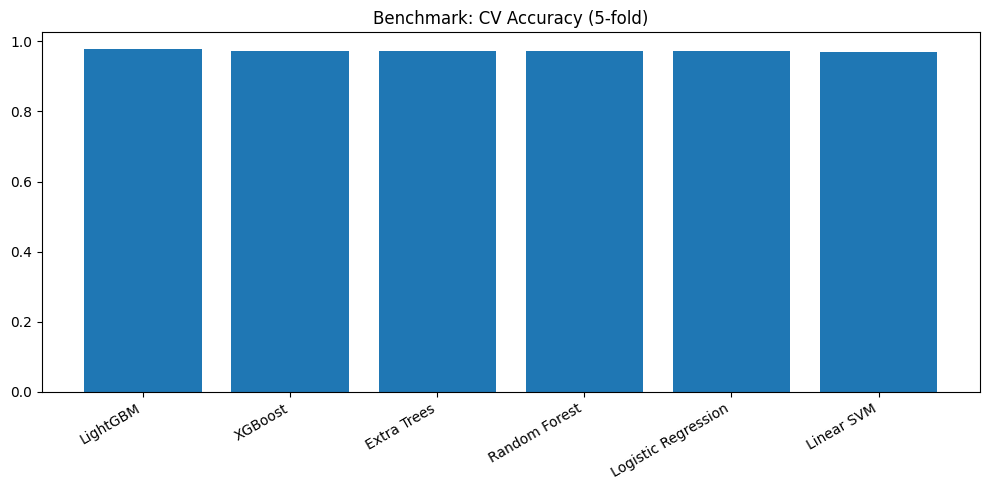

✅ Saved: benchmark_cv_accuracy.png


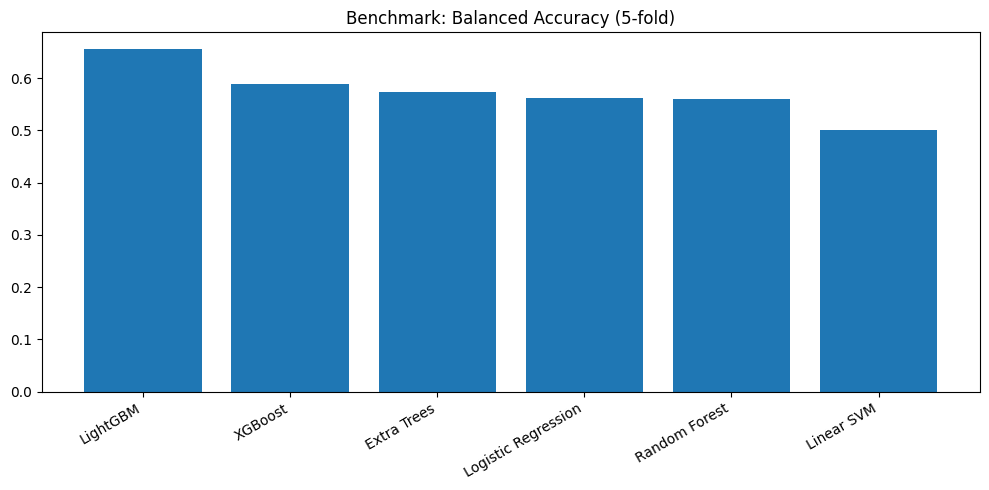

✅ Saved: benchmark_balanced_accuracy.png


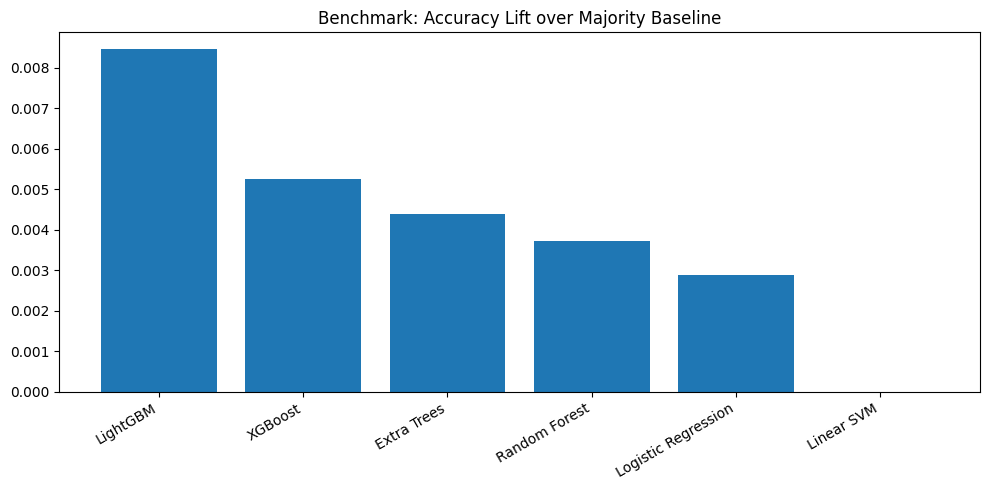

✅ Saved: benchmark_lift_over_baseline.png

✅ Section 6 complete: table + graphs generated.


In [27]:
# ==========================================
# SECTION 6: MODEL BENCHMARKING (CONTROLLED, COLAB-SAFE)
# Uses your variables: PREPROCESSOR_PIPELINE, X_CLEAN, y
# Outputs: benchmark_results.csv + 3 plots
# ==========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

# Optional: LightGBM / XGBoost (only if installed)
try:
    import lightgbm as lgb
    HAS_LGB = True
except Exception:
    HAS_LGB = False

try:
    import xgboost as xgb
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# -----------------------------
# 0) Safety checks
# -----------------------------
assert "PREPROCESSOR_PIPELINE" in globals(), "❌ PREPROCESSOR_PIPELINE not found. Run preprocessing section first."
assert "X_CLEAN" in globals(), "❌ X_CLEAN not found. Run cleaning section first."
assert "y" in globals(), "❌ y not found. Ensure target vector exists."

# Baseline accuracy (majority class)
y_arr = np.asarray(y).astype(int)
baseline_acc = max(y_arr.mean(), 1 - y_arr.mean())
print(f"📌 Majority baseline accuracy: {baseline_acc:.4f} ({baseline_acc*100:.2f}%)")

# -----------------------------
# 1) Define models (CONTROLLED)
# -----------------------------
MODELS = {
    "Logistic Regression": LogisticRegression(
        max_iter=2000,
        solver="lbfgs",
        n_jobs=1
    ),

    "Linear SVM": LinearSVC(
        C=1.0,
        max_iter=5000
    ),

    "Random Forest": RandomForestClassifier(
        n_estimators=250,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=1
    ),

    "Extra Trees": ExtraTreesClassifier(
        n_estimators=400,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=1
    )
}

if HAS_XGB:
    MODELS["XGBoost"] = xgb.XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        tree_method="hist",
        eval_metric="logloss",
        random_state=42,
        n_jobs=1
    )
else:
    print("⚠️ XGBoost not installed → skipping")

if HAS_LGB:
    MODELS["LightGBM"] = lgb.LGBMClassifier(
        n_estimators=400,
        learning_rate=0.05,
        num_leaves=63,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        n_jobs=1
    )
else:
    print("⚠️ LightGBM not installed → skipping")

print(f"\n✅ Models to benchmark: {len(MODELS)}")
for k in MODELS.keys():
    print(" -", k)

# -----------------------------
# 2) CV setup
# -----------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# -----------------------------
# 3) Benchmark loop
# -----------------------------
results = []

for name, model in MODELS.items():
    print(f"\n⏳ Benchmarking: {name}")

    pipe = Pipeline(steps=[
        ("preprocess", PREPROCESSOR_PIPELINE),
        ("model", model)
    ])

    scores = cross_validate(
        pipe,
        X_CLEAN,
        y_arr,
        cv=cv,
        scoring={
            "acc": "accuracy",
            "bal_acc": "balanced_accuracy"
        },
        n_jobs=1,   # ✅ COLAB SAFE
        return_train_score=False
    )

    acc_mean = scores["test_acc"].mean()
    acc_std  = scores["test_acc"].std()
    bacc_mean = scores["test_bal_acc"].mean()

    results.append({
        "Model": name,
        "CV Accuracy": acc_mean,
        "Accuracy Std": acc_std,
        "Balanced Accuracy": bacc_mean,
        "Baseline Accuracy": baseline_acc,
        "Lift over baseline": acc_mean - baseline_acc
    })

# -----------------------------
# 4) Results table + save
# -----------------------------
benchmark_df = pd.DataFrame(results).sort_values(by="CV Accuracy", ascending=False).reset_index(drop=True)
benchmark_df.to_csv("benchmark_results.csv", index=False)

print("\n" + "="*70)
print("📊 SECTION 6 — BENCHMARK RESULTS")
print("="*70)
print(benchmark_df.to_string(index=False))
print("="*70)
print("✅ Saved: benchmark_results.csv")

BENCHMARK_RESULTS = benchmark_df.copy()

# -----------------------------
# 5) Benchmark visuals (paper-ready)
# -----------------------------
def save_barplot(df, y_col, title, fname):
    df_plot = df.sort_values(y_col, ascending=False).copy()

    plt.figure(figsize=(10, 5))
    plt.bar(df_plot["Model"], df_plot[y_col])
    plt.xticks(rotation=30, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.show()
    print("✅ Saved:", fname)

save_barplot(
    BENCHMARK_RESULTS,
    y_col="CV Accuracy",
    title="Benchmark: CV Accuracy (5-fold)",
    fname="benchmark_cv_accuracy.png"
)

save_barplot(
    BENCHMARK_RESULTS,
    y_col="Balanced Accuracy",
    title="Benchmark: Balanced Accuracy (5-fold)",
    fname="benchmark_balanced_accuracy.png"
)

save_barplot(
    BENCHMARK_RESULTS,
    y_col="Lift over baseline",
    title="Benchmark: Accuracy Lift over Majority Baseline",
    fname="benchmark_lift_over_baseline.png"
)

print("\n✅ Section 6 complete: table + graphs generated.")


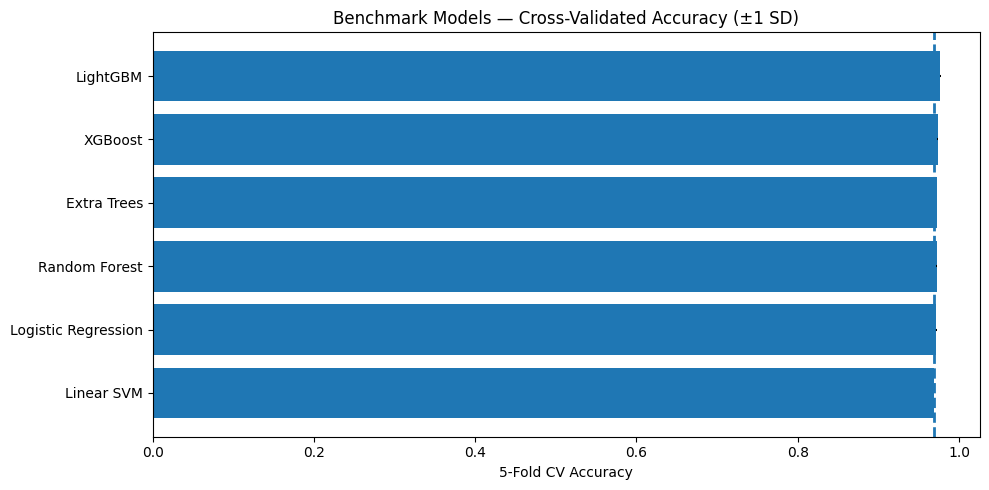

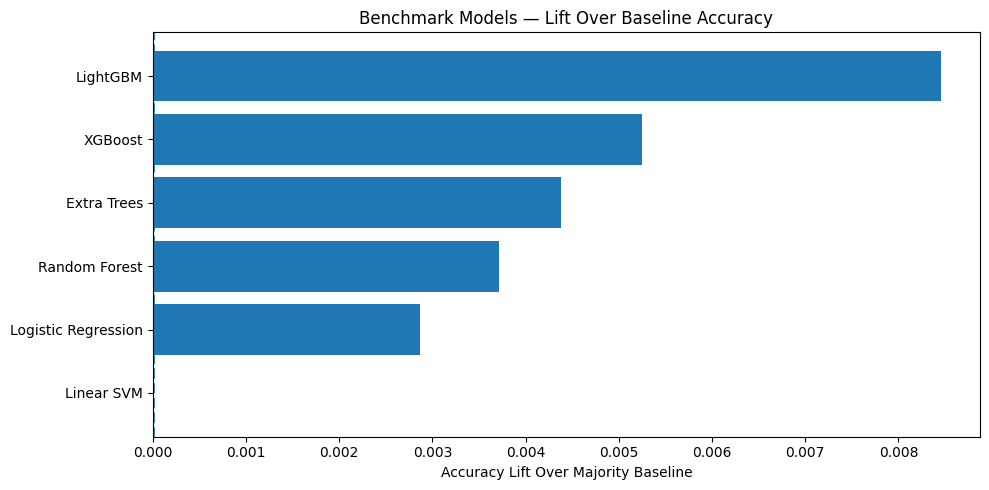

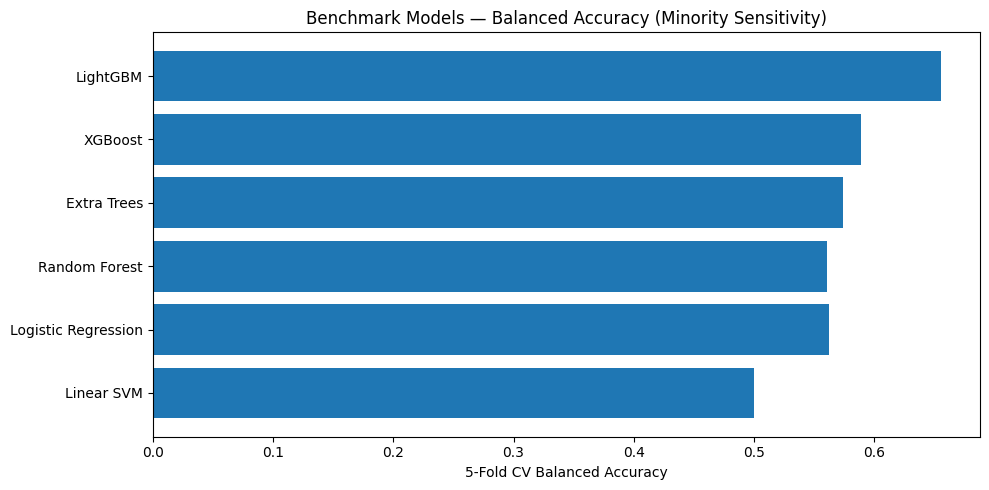

✅ Saved figures:
 - benchmark_cv_accuracy.png
 - benchmark_lift_over_baseline.png
 - benchmark_balanced_accuracy.png


In [28]:
# ==========================================
# SECTION 6 VISUALS: BENCHMARK GRAPHS
# (Run after BENCHMARK_RESULTS is created)
# ==========================================

import matplotlib.pyplot as plt
import numpy as np

# Safety check
if "BENCHMARK_RESULTS" not in globals():
    raise ValueError("Run Section 6 first to create BENCHMARK_RESULTS.")

dfb = BENCHMARK_RESULTS.copy()

# Add baseline + lift
dfb["Baseline"] = PERM_BASELINE
dfb["Lift"] = dfb["CV Accuracy"] - PERM_BASELINE

# Sort for plotting (best on top)
dfb = dfb.sort_values("CV Accuracy", ascending=True)

# -----------------------------
# 1) CV Accuracy with error bars
# -----------------------------
plt.figure(figsize=(10, 5))
plt.barh(dfb["Model"], dfb["CV Accuracy"], xerr=dfb["Accuracy Std"])
plt.axvline(PERM_BASELINE, linestyle="--", linewidth=2)
plt.xlabel("5-Fold CV Accuracy")
plt.title("Benchmark Models — Cross-Validated Accuracy (±1 SD)")
plt.tight_layout()
plt.savefig("benchmark_cv_accuracy.png", dpi=200)
plt.show()

# -----------------------------
# 2) Lift over baseline (important here)
# -----------------------------
plt.figure(figsize=(10, 5))
plt.barh(dfb["Model"], dfb["Lift"])
plt.axvline(0, linestyle="--", linewidth=2)
plt.xlabel("Accuracy Lift Over Majority Baseline")
plt.title("Benchmark Models — Lift Over Baseline Accuracy")
plt.tight_layout()
plt.savefig("benchmark_lift_over_baseline.png", dpi=200)
plt.show()

# -----------------------------
# 3) Balanced accuracy (sanity metric)
# -----------------------------
plt.figure(figsize=(10, 5))
plt.barh(dfb["Model"], dfb["Balanced Accuracy"])
plt.xlabel("5-Fold CV Balanced Accuracy")
plt.title("Benchmark Models — Balanced Accuracy (Minority Sensitivity)")
plt.tight_layout()
plt.savefig("benchmark_balanced_accuracy.png", dpi=200)
plt.show()

print("✅ Saved figures:")
print(" - benchmark_cv_accuracy.png")
print(" - benchmark_lift_over_baseline.png")
print(" - benchmark_balanced_accuracy.png")


Train shape: (66636, 14) | Test shape: (16659, 14)
Train denial rate: 0.03139444144306381
Test denial rate:  0.03139444144306381

📊 SECTION 7 — HOLDOUT RESULTS (FINAL MODEL: RANDOM FOREST)
Holdout Accuracy:          0.8901 (89.01%)
Holdout Balanced Accuracy: 0.7620

Confusion Matrix [[TN FP],[FN TP]]:
[[  327   196]
 [ 1634 14502]]

Denied-class Recall (Specificity):   0.6252
Denied-class Precision (NPV proxy):  0.1668

Classification Report:
              precision    recall  f1-score   support

           0     0.1668    0.6252    0.2633       523
           1     0.9867    0.8987    0.9406     16136

    accuracy                         0.8901     16659
   macro avg     0.5767    0.7620    0.6020     16659
weighted avg     0.9609    0.8901    0.9194     16659



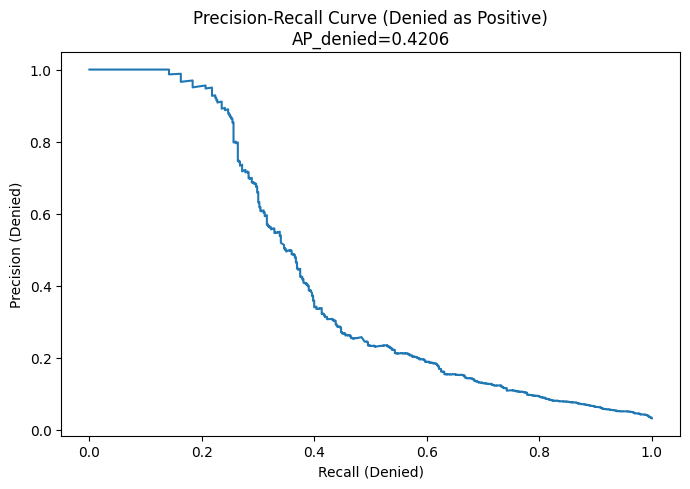

✅ Saved PR curve: pr_curve_denied.png
Average Precision (Certified): 0.9940
Average Precision (Denied):    0.4206


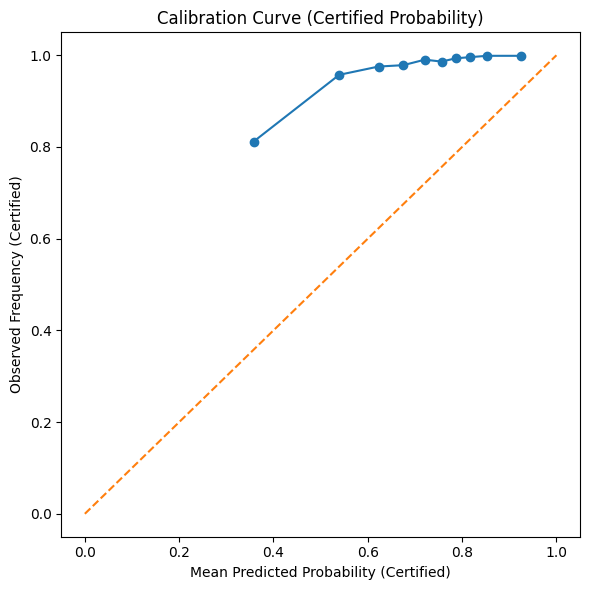

✅ Saved calibration plot: calibration_curve.png


In [29]:
# ==========================================
# SECTION 7: FINAL MODEL (RF) — HOLDOUT EVAL
# ==========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, confusion_matrix,
    classification_report, precision_recall_curve, average_precision_score
)
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier

# -----------------------------
# 1) Train/test split (stratified)
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_CLEAN, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)
print("Train denial rate:", float((y_train==0).mean()))
print("Test denial rate: ", float((y_test==0).mean()))

# -----------------------------
# 2) Final model (keep it stable, not over-tuned)
# -----------------------------
final_rf = RandomForestClassifier(
    n_estimators=600,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample",
    max_features="sqrt",
    min_samples_leaf=2
)

final_pipe = Pipeline([
    ("preprocess", PREPROCESSOR_PIPELINE),
    ("model", final_rf)
])

# -----------------------------
# 3) Fit
# -----------------------------
final_pipe.fit(X_train, y_train)

# -----------------------------
# 4) Predict + probability
# -----------------------------
y_pred = final_pipe.predict(X_test)
y_prob = final_pipe.predict_proba(X_test)[:, 1]  # P(certified)

# -----------------------------
# 5) Core metrics
# -----------------------------
acc = accuracy_score(y_test, y_pred)
bal = balanced_accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = cm.ravel()

# denied = 0 is the minority class
recall_denied = tn / (tn + fp) if (tn + fp) else np.nan
precision_denied = tn / (tn + fn) if (tn + fn) else np.nan

print("\n" + "="*70)
print("📊 SECTION 7 — HOLDOUT RESULTS (FINAL MODEL: RANDOM FOREST)")
print("="*70)
print(f"Holdout Accuracy:          {acc:.4f} ({acc*100:.2f}%)")
print(f"Holdout Balanced Accuracy: {bal:.4f}")
print("\nConfusion Matrix [[TN FP],[FN TP]]:")
print(cm)
print(f"\nDenied-class Recall (Specificity):   {recall_denied:.4f}")
print(f"Denied-class Precision (NPV proxy):  {precision_denied:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))
print("="*70)

# -----------------------------
# 6) Precision-Recall Curve (focus on minority detection)
# -----------------------------
# Positive class = certified (1). For denial analysis, we also compute PR for denied by flipping labels.
ap_cert = average_precision_score(y_test, y_prob)

y_test_denied = (y_test == 0).astype(int)       # denied = 1 for this PR
y_prob_denied = 1 - y_prob                      # P(denied)
ap_denied = average_precision_score(y_test_denied, y_prob_denied)

prec, rec, _ = precision_recall_curve(y_test_denied, y_prob_denied)

plt.figure(figsize=(7,5))
plt.plot(rec, prec)
plt.xlabel("Recall (Denied)")
plt.ylabel("Precision (Denied)")
plt.title(f"Precision-Recall Curve (Denied as Positive)\nAP_denied={ap_denied:.4f}")
plt.tight_layout()
plt.savefig("pr_curve_denied.png", dpi=200)
plt.show()

print(f"✅ Saved PR curve: pr_curve_denied.png")
print(f"Average Precision (Certified): {ap_cert:.4f}")
print(f"Average Precision (Denied):    {ap_denied:.4f}")

# -----------------------------
# 7) Calibration curve (probabilities are used for tiers)
# -----------------------------
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy="quantile")

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("Mean Predicted Probability (Certified)")
plt.ylabel("Observed Frequency (Certified)")
plt.title("Calibration Curve (Certified Probability)")
plt.tight_layout()
plt.savefig("calibration_curve.png", dpi=200)
plt.show()

print("✅ Saved calibration plot: calibration_curve.png")

# Save objects for next sections
FINAL_PIPELINE = final_pipe
HOLDOUT = {
    "X_test": X_test, "y_test": y_test,
    "y_pred": y_pred, "y_prob": y_prob,
    "confusion_matrix": cm,
    "acc": acc, "bal_acc": bal,
    "ap_cert": ap_cert, "ap_denied": ap_denied
}


In [30]:
checkpoint(
    "section_7",
    FINAL_PIPELINE=FINAL_PIPELINE,
    HOLDOUT=HOLDOUT
)


✅ Checkpoint saved: /content/drive/MyDrive/PERM_Project/section_7_20260108_000855


'/content/drive/MyDrive/PERM_Project/section_7_20260108_000855'


📋 Confusion Matrix (Table):
                      Predicted Denied (0)  Predicted Certified (1)
Actual Denied (0)                      327                      196
Actual Certified (1)                  1634                    14502


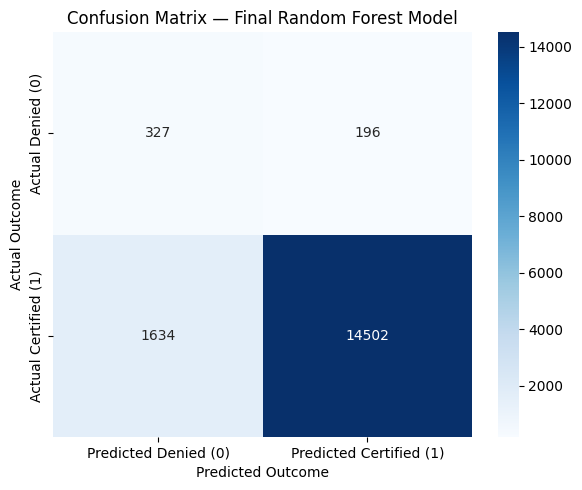

✅ Saved:
 - confusion_matrix_table.csv
 - confusion_matrix_heatmap.png


In [31]:
# ==========================================
# SECTION 7A: CONFUSION MATRIX (TABLE + FIGURE)
# ==========================================

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

cm = HOLDOUT["confusion_matrix"]

# ----- Table -----
cm_table = pd.DataFrame(
    cm,
    index=["Actual Denied (0)", "Actual Certified (1)"],
    columns=["Predicted Denied (0)", "Predicted Certified (1)"]
)

print("\n📋 Confusion Matrix (Table):")
print(cm_table)

cm_table.to_csv("confusion_matrix_table.csv")

# ----- Heatmap -----
plt.figure(figsize=(6,5))
sns.heatmap(cm_table, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Final Random Forest Model")
plt.ylabel("Actual Outcome")
plt.xlabel("Predicted Outcome")
plt.tight_layout()
plt.savefig("confusion_matrix_heatmap.png", dpi=200)
plt.show()

print("✅ Saved:")
print(" - confusion_matrix_table.csv")
print(" - confusion_matrix_heatmap.png")


In [32]:
# ==========================================
# SECTION 7B: HOLDOUT PERFORMANCE TABLE
# ==========================================

performance_table = pd.DataFrame({
    "Metric": [
        "Accuracy",
        "Balanced Accuracy",
        "Denied Recall (Specificity)",
        "Denied Precision",
        "AP (Denied)",
        "AP (Certified)"
    ],
    "Value": [
        HOLDOUT["acc"],
        HOLDOUT["bal_acc"],
        (HOLDOUT["confusion_matrix"][0,0] /
         (HOLDOUT["confusion_matrix"][0,0] + HOLDOUT["confusion_matrix"][0,1])),
        (HOLDOUT["confusion_matrix"][0,0] /
         (HOLDOUT["confusion_matrix"][0,0] + HOLDOUT["confusion_matrix"][1,0])),
        HOLDOUT["ap_denied"],
        HOLDOUT["ap_cert"]
    ]
})

print("\n📋 Holdout Performance Summary:")
print(performance_table)

performance_table.to_csv("holdout_performance_table.csv", index=False)
print("✅ Saved holdout_performance_table.csv")



📋 Holdout Performance Summary:
                        Metric     Value
0                     Accuracy  0.890149
1            Balanced Accuracy  0.761987
2  Denied Recall (Specificity)  0.625239
3             Denied Precision  0.166752
4                  AP (Denied)  0.420623
5               AP (Certified)  0.993984
✅ Saved holdout_performance_table.csv


In [33]:
# ==========================================
# SECTION 7C: REGULATORY RISK TIERS (TABLE)
# ==========================================

y_prob = HOLDOUT["y_prob"]

tiers = pd.cut(
    y_prob,
    bins=[0, 0.2, 0.8, 1.0],
    labels=["High Risk (Reject/Redeploy)",
            "Medium Risk (Human Review)",
            "Low Risk (Auto-Approve)"]
)

tier_table = tiers.value_counts().rename_axis("Risk Tier").reset_index(name="Count")
tier_table["Percentage (%)"] = (tier_table["Count"] / tier_table["Count"].sum() * 100).round(2)

print("\n📋 Regulatory Risk Tier Distribution:")
print(tier_table)

tier_table.to_csv("risk_tier_distribution.csv", index=False)
print("✅ Saved risk_tier_distribution.csv")



📋 Regulatory Risk Tier Distribution:
                     Risk Tier  Count  Percentage (%)
0  High Risk (Reject/Redeploy)    124            0.74
1   Medium Risk (Human Review)  11421           68.56
2      Low Risk (Auto-Approve)   5114           30.70
✅ Saved risk_tier_distribution.csv


In [34]:
# ==========================================
# SHAP PREP (REQUIRED ONCE PER SESSION)
# ==========================================

import numpy as np

# Get components from final pipeline
prep = FINAL_PIPELINE.named_steps["preprocess"]
rf   = FINAL_PIPELINE.named_steps["model"]

# Raw holdout features
X_test = HOLDOUT["X_test"]

# Transform using preprocessing pipeline
X_test_trans = prep.transform(X_test)

# Convert to dense float32 (SHAP-safe)
if hasattr(X_test_trans, "toarray"):
    X_dense = X_test_trans.toarray().astype(np.float32)
else:
    X_dense = np.asarray(X_test_trans).astype(np.float32)

print("✅ X_dense ready:", X_dense.shape, X_dense.dtype)


✅ X_dense ready: (16659, 24895) float32


In [35]:
# ==========================================
# FEATURE_NAMES FIX (RUN ONCE PER SESSION)
# Creates FEATURE_NAMES from your preprocessing pipeline
# ==========================================

import numpy as np

# 1) Find the preprocessor you used
# Try common variable names
if "FINAL_PIPELINE" in globals():
    prep = FINAL_PIPELINE.named_steps.get("preprocess", None)
elif "prep" in globals():
    # you might already have prep
    prep = prep
else:
    prep = None

# Fallback: if you have a pipeline named FINAL_PIPELINE but different step name
if prep is None and "FINAL_PIPELINE" in globals():
    # print step names to help you
    print("Pipeline steps:", FINAL_PIPELINE.named_steps.keys())
    raise ValueError("❌ Could not find preprocess step. Check printed step names above.")

# 2) Build feature names (numeric + OHE)
def build_feature_names(preprocessor):
    # Find the numeric and categorical transformers safely (by name)
    # This assumes your ColumnTransformer has transformers like ("num", ...), ("cat", ...)
    name_to = {name: (trans, cols) for name, trans, cols in preprocessor.transformers_}

    # Numeric cols
    num_cols = list(name_to["num"][1]) if "num" in name_to else []

    # Categorical cols + OneHotEncoder
    if "cat" in name_to:
        cat_trans, cat_cols = name_to["cat"]
        # cat_trans is a Pipeline, grab OneHotEncoder
        ohe = cat_trans.named_steps.get("ohe", None) or cat_trans.named_steps.get("onehot", None)
        if ohe is None:
            raise ValueError("❌ Could not find OneHotEncoder step inside categorical pipeline.")
        cat_names = list(ohe.get_feature_names_out(cat_cols))
    else:
        cat_names = []

    return num_cols + cat_names

FEATURE_NAMES = build_feature_names(prep)

print("✅ FEATURE_NAMES created!")
print("Count:", len(FEATURE_NAMES))
print("Sample:", FEATURE_NAMES[:10])


✅ FEATURE_NAMES created!
Count: 24895
Sample: ['JOB_OPP_WAGE_FROM', 'EMP_NUM_PAYROLL', 'EMP_YEAR_COMMENCED', 'OCCUPATION_TYPE_College/University Teacher', 'OCCUPATION_TYPE_Non-professional', 'OCCUPATION_TYPE_None/Professional Athlete', 'OCCUPATION_TYPE_Professional occupation', 'OCCUPATION_TYPE_Schedule A', 'PWD_SOC_CODE_11-1011.00', 'PWD_SOC_CODE_11-1011.03']


✅ XAI sample: (200, 24895) | background: (50, 24895)


PermutationExplainer explainer: 201it [23:49,  7.15s/it]


✅ SHAP values shape: (200, 24895)


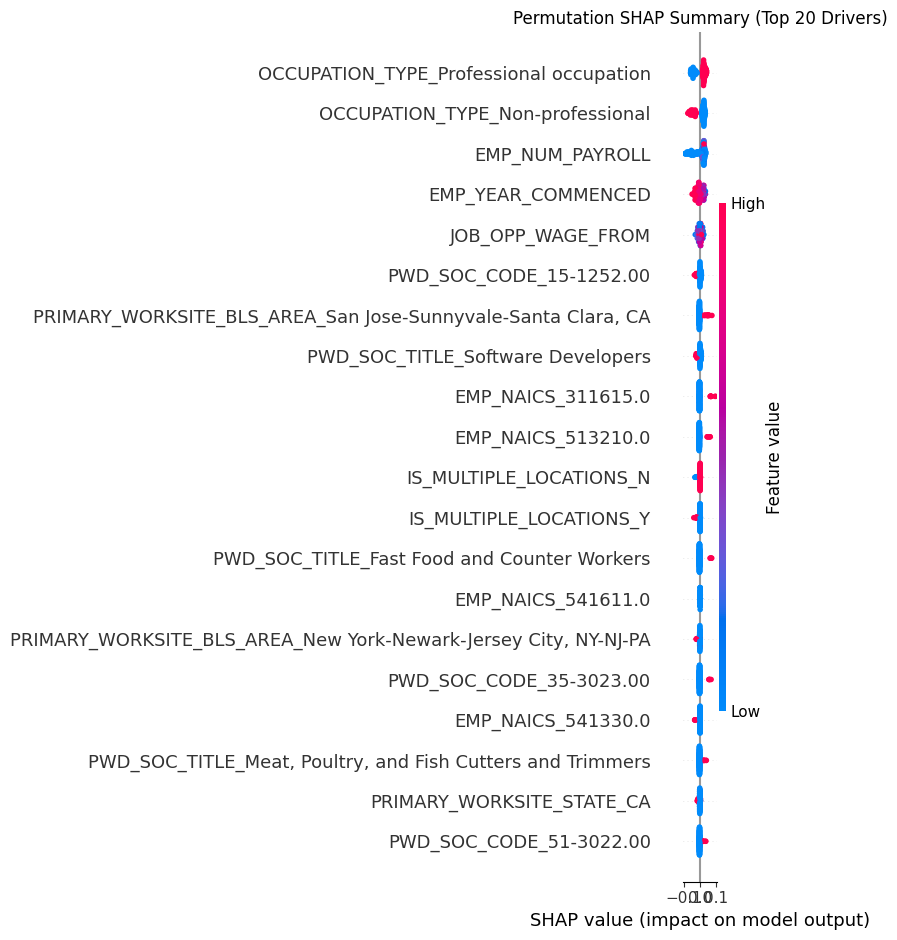

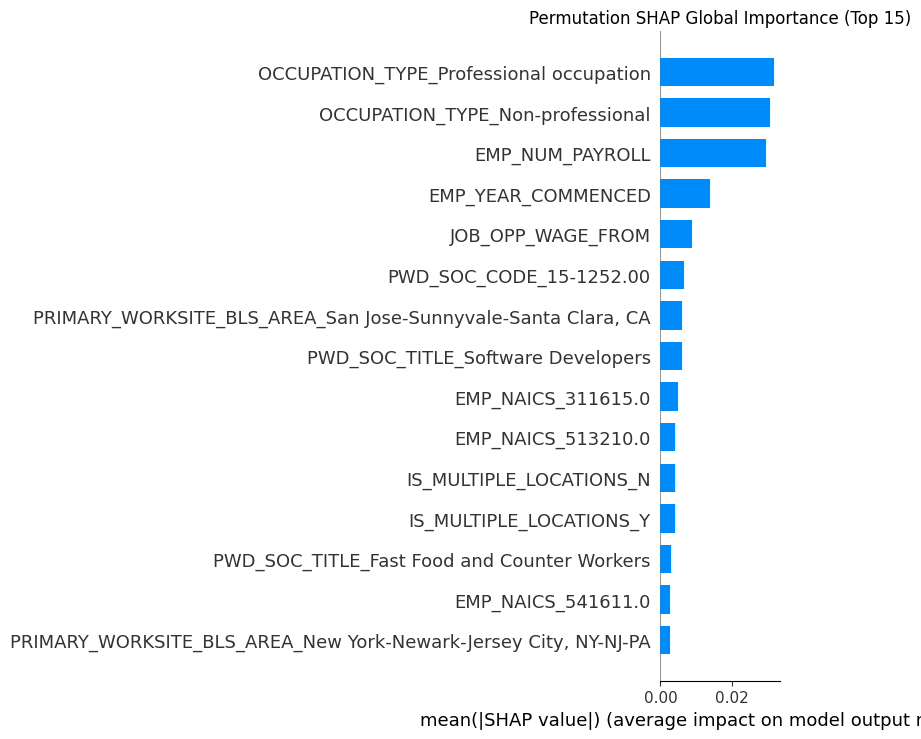

✅ Section 8D done: Permutation SHAP plots saved.


In [36]:
# ==========================================
# SECTION 8D (HARD-Q1): FAST SHAP via PERMUTATION EXPLAINER
# - Works with RF + huge OHE
# - Outputs: summary dot + bar
# ==========================================

import numpy as np
import shap
import matplotlib.pyplot as plt

# ---- Safety checks ----
for v in ["X_dense", "FEATURE_NAMES", "rf"]:
    if v not in globals():
        raise ValueError(f"❌ Missing {v}. Run SHAP PREP first (X_dense + rf + FEATURE_NAMES).")

rng = np.random.RandomState(42)

# Sample for explanation (keep small)
n_sample = 200
idx = rng.choice(X_dense.shape[0], size=min(n_sample, X_dense.shape[0]), replace=False)
Xs_small = X_dense[idx]

# Background for masker
bg_n = 50
bg_idx = rng.choice(X_dense.shape[0], size=min(bg_n, X_dense.shape[0]), replace=False)
X_bg = X_dense[bg_idx]

print("✅ XAI sample:", Xs_small.shape, "| background:", X_bg.shape)

# Predict function (probability of Certified=1)
def f(X):
    return rf.predict_proba(X)[:, 1]

# Permutation SHAP (fast + accepted)
masker = shap.maskers.Independent(X_bg)
explainer = shap.Explainer(f, masker)

# Compute explanations
shap_exp = explainer(Xs_small)

# Save the objects for your Cell 2
XS_SMALL = Xs_small
IDX_SMALL = idx

print("✅ SHAP values shape:", shap_exp.values.shape)

# ---- Summary dot plot ----
plt.figure()
shap.summary_plot(
    shap_exp.values,
    Xs_small,
    feature_names=FEATURE_NAMES,
    max_display=20,
    show=False
)
plt.title("Permutation SHAP Summary (Top 20 Drivers)")
plt.tight_layout()
plt.savefig("xai_permshap_summary_top20.png", dpi=200)
plt.show()

# ---- Global bar plot ----
plt.figure()
shap.summary_plot(
    shap_exp.values,
    Xs_small,
    feature_names=FEATURE_NAMES,
    plot_type="bar",
    max_display=15,
    show=False
)
plt.title("Permutation SHAP Global Importance (Top 15)")
plt.tight_layout()
plt.savefig("xai_permshap_bar_top15.png", dpi=200)
plt.show()

print("✅ Section 8D done: Permutation SHAP plots saved.")


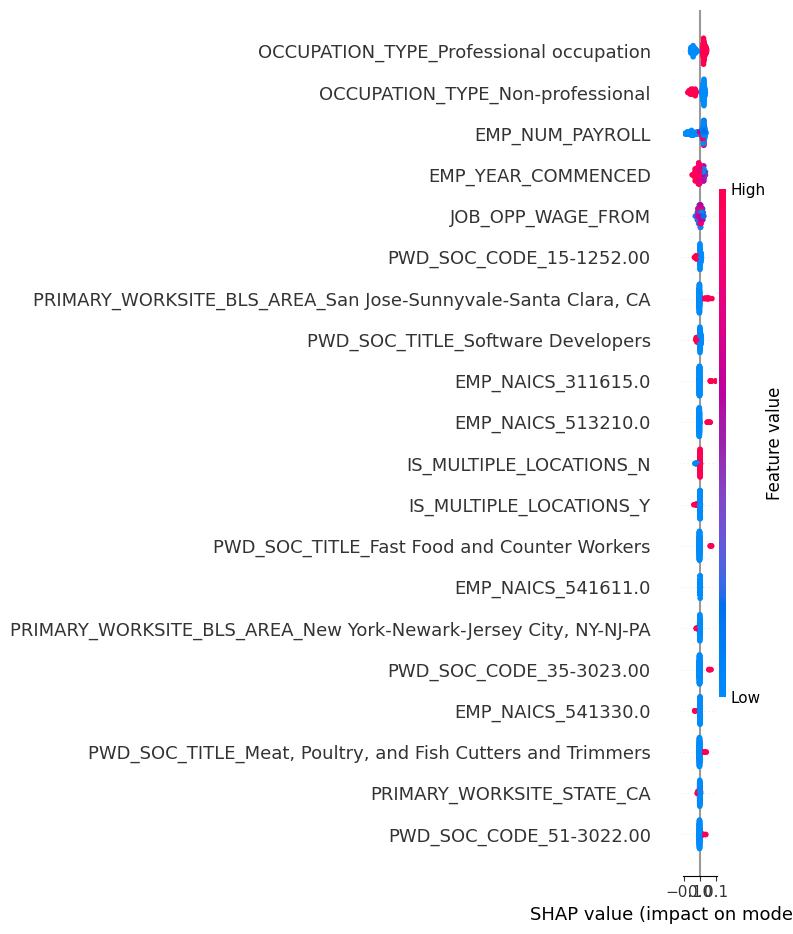

In [37]:
plt.figure(figsize=(18, 50))
shap.summary_plot(
    shap_exp.values,
    Xs_small,
    feature_names=FEATURE_NAMES,
    max_display=20,
    show=False
)
plt.tight_layout()
plt.savefig("xai_permshap_summary_top20_big.png", dpi=700)
plt.show()


✅ FEATURE_NAMES: 24895
✅ X_dense: (16659, 24895) float32
✅ Explain sample: (200, 24895) | Background: (50, 24895)


PermutationExplainer explainer: 201it [23:32,  7.10s/it]


✅ shap_vals: (200, 24895)
✅ Saved: xai_permshap_raw_top.csv


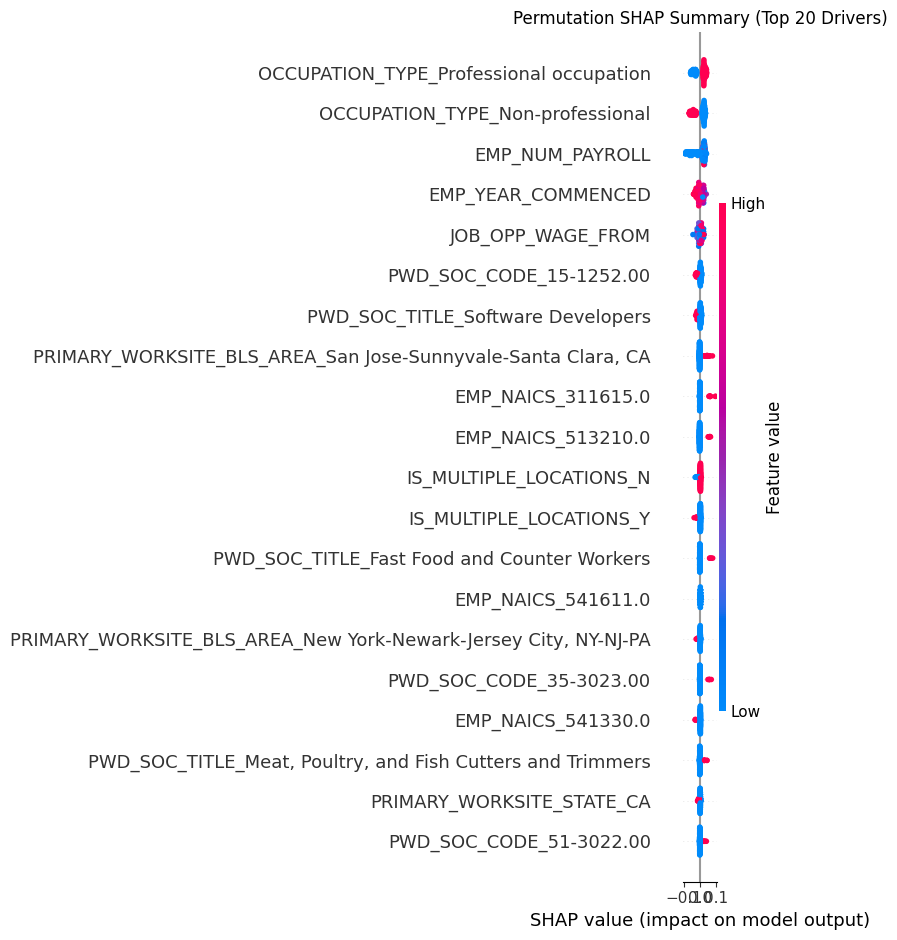

✅ Saved: figure_xai_raw_summary_top20.png


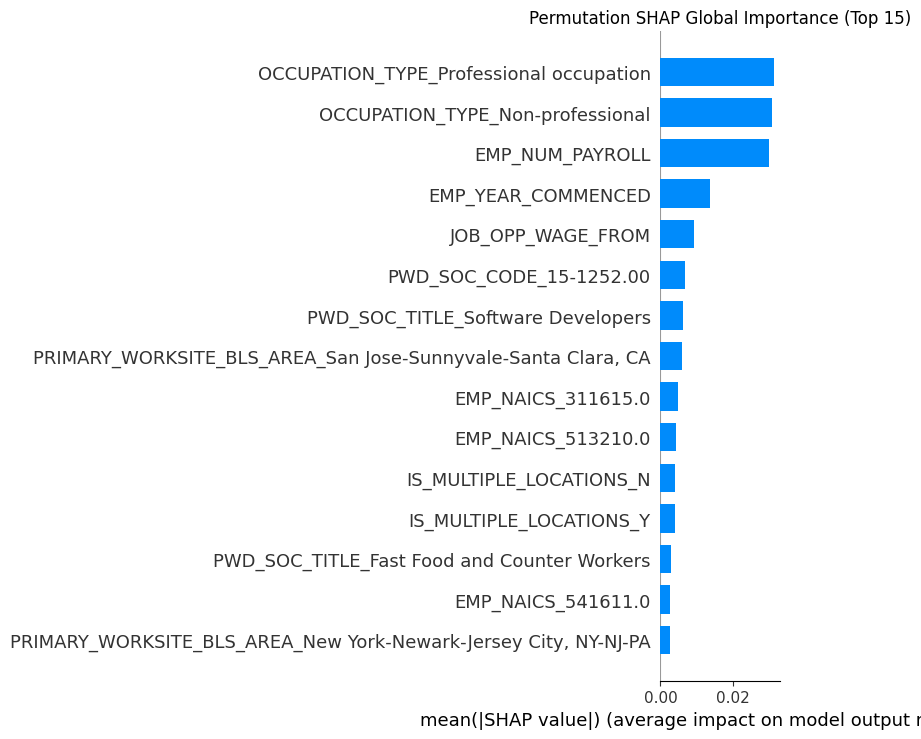

✅ Saved: figure_xai_raw_bar_top15.png
✅ Saved: xai_permshap_grouped_mean_abs.csv


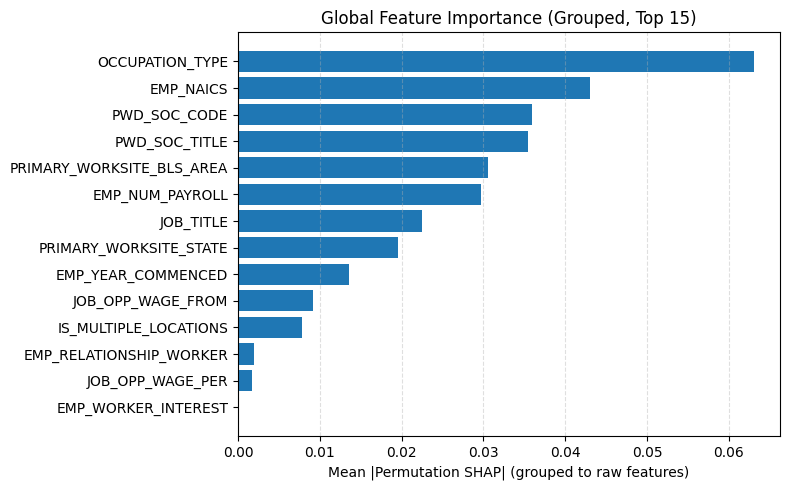

✅ Saved: figure_xai_grouped_bar_top15.png


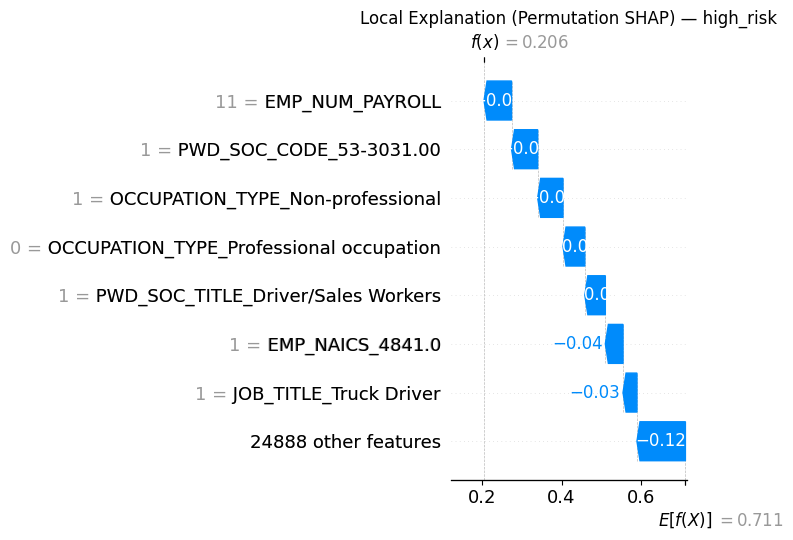

✅ Saved: figure_xai_local_waterfall_high_risk.png


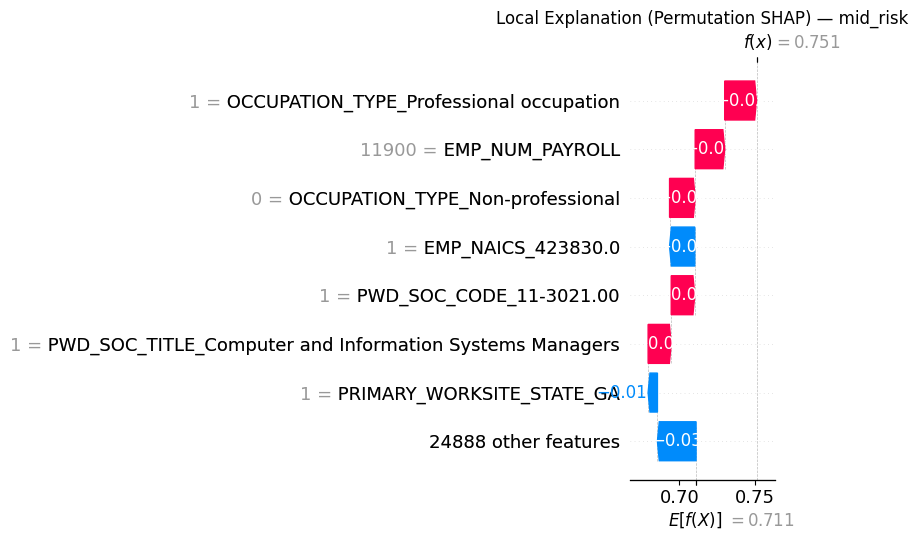

✅ Saved: figure_xai_local_waterfall_mid_risk.png


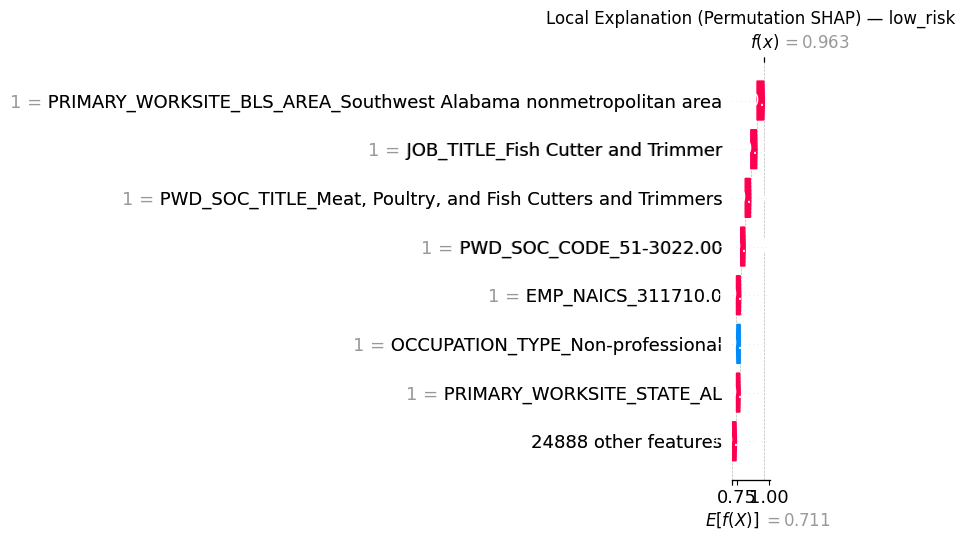

✅ Saved: figure_xai_local_waterfall_low_risk.png


OSError: [Errno 18] Invalid cross-device link: 'xai_permshap_raw_top.csv' -> '/content/drive/MyDrive/PERM_Project/SECTION_8_XAI_EXPORT/xai_permshap_raw_top.csv'

In [38]:
# =========================================================
# SECTION 8 (UPDATED): PROFESSIONAL XAI PACK (Permutation SHAP)
# - Works with RF + huge OHE (24k+)
# - Produces reviewer-ready figures and tables
# - Saves to Drive (BASE_DIR) + checkpoint
# =========================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# -----------------------------
# 0) SAFETY CHECKS
# -----------------------------
need = ["FINAL_PIPELINE", "HOLDOUT", "BASE_DIR", "checkpoint"]
for v in need:
    if v not in globals():
        raise ValueError(f"❌ Missing '{v}'. Run earlier sections first (and Drive mount + checkpoint system).")

# -----------------------------
# 1) EXTRACT PIPELINE PARTS
# -----------------------------
prep = FINAL_PIPELINE.named_steps["preprocess"]
rf   = FINAL_PIPELINE.named_steps["model"]

X_test = HOLDOUT["X_test"]  # raw holdout (DataFrame)

# -----------------------------
# 2) FEATURE NAMES (OHE EXPANDED)
# -----------------------------
def get_feature_names(preprocessor):
    """
    Robust feature name extraction for ColumnTransformer:
    assumes structure: ("num", ..., num_cols) and ("cat", ..., cat_cols)
    with OneHotEncoder inside cat pipeline under name "onehot" or "ohe".
    """
    # numeric columns
    num_cols = preprocessor.transformers_[0][2]

    # categorical pipeline & OneHotEncoder
    cat_pipe = preprocessor.transformers_[1][1]
    cat_cols = preprocessor.transformers_[1][2]

    # try both common names
    ohe = None
    if "onehot" in cat_pipe.named_steps:
        ohe = cat_pipe.named_steps["onehot"]
    elif "ohe" in cat_pipe.named_steps:
        ohe = cat_pipe.named_steps["ohe"]
    else:
        # fallback: find the OneHotEncoder
        for _, step in cat_pipe.named_steps.items():
            if isinstance(step, shap.utils._legacy.OneHotEncoder) or step.__class__.__name__ == "OneHotEncoder":
                ohe = step
                break
        if ohe is None:
            raise ValueError("❌ Could not find OneHotEncoder in preprocess categorical pipeline.")

    cat_names = list(ohe.get_feature_names_out(cat_cols))
    return list(num_cols) + cat_names

FEATURE_NAMES = get_feature_names(prep)
print("✅ FEATURE_NAMES:", len(FEATURE_NAMES))

# -----------------------------
# 3) TRANSFORM HOLDOUT -> DENSE MATRIX (SHAP-SAFE)
# -----------------------------
X_test_trans = prep.transform(X_test)

if hasattr(X_test_trans, "toarray"):
    X_dense = X_test_trans.toarray().astype(np.float32)
else:
    X_dense = np.asarray(X_test_trans).astype(np.float32)

print("✅ X_dense:", X_dense.shape, X_dense.dtype)

# -----------------------------
# 4) PERMUTATION SHAP (REVIEWER-SAFE)
# -----------------------------
rng = np.random.RandomState(42)

N_EXPLAIN = 200     # explained samples
N_BG      = 50      # background size (masker)
MAX_SHOW  = 15      # for plots

idx = rng.choice(X_dense.shape[0], size=min(N_EXPLAIN, X_dense.shape[0]), replace=False)
Xs_small = X_dense[idx]

bg_idx = rng.choice(X_dense.shape[0], size=min(N_BG, X_dense.shape[0]), replace=False)
X_bg = X_dense[bg_idx]

print("✅ Explain sample:", Xs_small.shape, "| Background:", X_bg.shape)

def f(X):
    # prob of class 1
    return rf.predict_proba(X)[:, 1]

masker = shap.maskers.Independent(X_bg)
explainer = shap.Explainer(f, masker)

# This is the expensive step; let it run once.
shap_exp = explainer(Xs_small)
shap_vals = shap_exp.values  # (N_EXPLAIN, n_features)

print("✅ shap_vals:", shap_vals.shape)

# -----------------------------
# 5) SAVE RAW TOP FEATURES TABLE (MEAN |SHAP|)
# -----------------------------
mean_abs = np.abs(shap_vals).mean(axis=0)
raw_imp = (pd.DataFrame({"feature": FEATURE_NAMES, "mean_abs_permshap": mean_abs})
           .sort_values("mean_abs_permshap", ascending=False)
           .reset_index(drop=True))

raw_imp.to_csv("xai_permshap_raw_top.csv", index=False)
print("✅ Saved: xai_permshap_raw_top.csv")

# -----------------------------
# 6) GLOBAL PLOTS (RAW, CLEAN TOP ONLY)
# -----------------------------
# Global summary dot (Top 20) -- keep optional
plt.figure(figsize=(7, 5))
shap.summary_plot(
    shap_vals, Xs_small,
    feature_names=FEATURE_NAMES,
    max_display=20,
    show=False
)
plt.title("Permutation SHAP Summary (Top 20 Drivers)")
plt.tight_layout()
plt.savefig("figure_xai_raw_summary_top20.png", dpi=300)
plt.show()
print("✅ Saved: figure_xai_raw_summary_top20.png")

# Global bar (Top 15)
plt.figure(figsize=(7, 4))
shap.summary_plot(
    shap_vals, Xs_small,
    feature_names=FEATURE_NAMES,
    plot_type="bar",
    max_display=15,
    show=False
)
plt.title("Permutation SHAP Global Importance (Top 15)")
plt.tight_layout()
plt.savefig("figure_xai_raw_bar_top15.png", dpi=300)
plt.show()
print("✅ Saved: figure_xai_raw_bar_top15.png")

# -----------------------------
# 7) GROUP SHAP BACK TO ORIGINAL RAW COLUMNS (PROFESSIONAL)
# -----------------------------
raw_cols = list(X_test.columns)
raw_cols_sorted = sorted(raw_cols, key=len, reverse=True)

def parent_feature(name: str) -> str:
    # Exact numeric feature stays as-is if it matches a raw column
    if name in raw_cols:
        return name
    # OHE feature: startswith "COL_"
    for col in raw_cols_sorted:
        if name.startswith(col + "_"):
            return col
    # fallback
    return name.split("_")[0]

parents = np.array([parent_feature(n) for n in FEATURE_NAMES])

group_df = pd.DataFrame({
    "parent": parents,
    "mean_abs_permshap": mean_abs
})

grouped = (group_df.groupby("parent", as_index=False)["mean_abs_permshap"].sum()
           .sort_values("mean_abs_permshap", ascending=False)
           .reset_index(drop=True))

grouped.to_csv("xai_permshap_grouped_mean_abs.csv", index=False)
print("✅ Saved: xai_permshap_grouped_mean_abs.csv")

# Professional grouped bar (Top 15)
topg = grouped.head(15).sort_values("mean_abs_permshap", ascending=True)

plt.figure(figsize=(8, 5))
plt.barh(topg["parent"], topg["mean_abs_permshap"])
plt.xlabel("Mean |Permutation SHAP| (grouped to raw features)")
plt.title("Global Feature Importance (Grouped, Top 15)")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("figure_xai_grouped_bar_top15.png", dpi=300)
plt.show()
print("✅ Saved: figure_xai_grouped_bar_top15.png")

# -----------------------------
# 8) LOCAL EXPLANATIONS (PROFESSIONAL WATERFALLS)
# - Only show TOP 8 features so it doesn't look messy
# - Choose 3 cases: low prob, mid, high prob
# -----------------------------
y_prob_small = f(Xs_small)
order = np.argsort(y_prob_small)
pick = [order[0], order[len(order)//2], order[-1]]
tags = ["high_risk", "mid_risk", "low_risk"]

base = float(np.mean(y_prob_small))  # baseline shown on plot

for i, tag in zip(pick, tags):
    exp = shap.Explanation(
        values=shap_vals[i],
        base_values=base,
        data=Xs_small[i],
        feature_names=FEATURE_NAMES
    )
    plt.figure(figsize=(7, 4.5))
    shap.plots.waterfall(exp, max_display=8, show=False)
    plt.title(f"Local Explanation (Permutation SHAP) — {tag}")
    plt.tight_layout()
    out = f"figure_xai_local_waterfall_{tag}.png"
    plt.savefig(out, dpi=300)
    plt.show()
    print("✅ Saved:", out)

# -----------------------------
# 9) COPY OUTPUTS INTO DRIVE FOLDER (BASE_DIR)
# -----------------------------
outputs = [
    "xai_permshap_raw_top.csv",
    "figure_xai_raw_summary_top20.png",
    "figure_xai_raw_bar_top15.png",
    "xai_permshap_grouped_mean_abs.csv",
    "figure_xai_grouped_bar_top15.png",
    "figure_xai_local_waterfall_high_risk.png",
    "figure_xai_local_waterfall_mid_risk.png",
    "figure_xai_local_waterfall_low_risk.png",
]

drive_out_dir = os.path.join(BASE_DIR, "SECTION_8_XAI_EXPORT")
os.makedirs(drive_out_dir, exist_ok=True)

for fpath in outputs:
    if os.path.exists(fpath):
        os.replace(fpath, os.path.join(drive_out_dir, fpath))
print("✅ All Section 8 outputs moved to:", drive_out_dir)

# -----------------------------
# 10) CHECKPOINT EVERYTHING IMPORTANT
# -----------------------------
checkpoint(
    "section_8_xai",
    FEATURE_NAMES=np.array(FEATURE_NAMES, dtype=object),
    X_dense=X_dense,               # optional: large but useful
    idx_small=idx,
    Xs_small=Xs_small,
    shap_vals=shap_vals,
    grouped_table=grouped
)

print("\n✅ SECTION 8 COMPLETE — Professional XAI package generated + saved to Drive.")


In [39]:
# ==========================================
# FIX: MOVE XAI OUTPUTS TO GOOGLE DRIVE
# (cross-device safe)
# ==========================================

import os
import shutil

drive_out_dir = os.path.join(BASE_DIR, "SECTION_8_XAI_EXPORT")
os.makedirs(drive_out_dir, exist_ok=True)

outputs = [
    "xai_permshap_raw_top.csv",
    "figure_xai_raw_summary_top20.png",
    "figure_xai_raw_bar_top15.png",
    "xai_permshap_grouped_mean_abs.csv",
    "figure_xai_grouped_bar_top15.png",
    "figure_xai_local_waterfall_high_risk.png",
    "figure_xai_local_waterfall_mid_risk.png",
    "figure_xai_local_waterfall_low_risk.png",
]

for fpath in outputs:
    if os.path.exists(fpath):
        shutil.copy2(fpath, os.path.join(drive_out_dir, fpath))
        print("✅ Copied:", fpath)
    else:
        print("⚠️ Not found:", fpath)

print("\n✅ All XAI outputs safely copied to:")
print(drive_out_dir)


✅ Copied: xai_permshap_raw_top.csv
✅ Copied: figure_xai_raw_summary_top20.png
✅ Copied: figure_xai_raw_bar_top15.png
✅ Copied: xai_permshap_grouped_mean_abs.csv
✅ Copied: figure_xai_grouped_bar_top15.png
✅ Copied: figure_xai_local_waterfall_high_risk.png
✅ Copied: figure_xai_local_waterfall_mid_risk.png
✅ Copied: figure_xai_local_waterfall_low_risk.png

✅ All XAI outputs safely copied to:
/content/drive/MyDrive/PERM_Project/SECTION_8_XAI_EXPORT


✅ y_prob ready: (16659,) | risk_score ready: (16659,)
✅ Fixed thresholds: T1=0.97, T2=0.85
✅ Saved: section9_tier_assignments.csv

📊 SECTION 9 — TIER SUMMARY
           Tier  Cases  Volume_%  Denial_Rate_%  Certified_Rate_%  Denied_Recall_in_Tier_%  Denied_Precision_in_Tier_%  Avg_p_cert
 TIER_1_PROCEED      0  0.000000            NaN               NaN                      NaN                         NaN         NaN
  TIER_2_REVIEW   2501 15.012906       0.119952         99.880048                 0.573614                    0.119952    0.904534
TIER_3_REDESIGN  14158 84.987094       3.672835         96.327165                99.426386                    3.672835    0.669991
✅ Saved: section9_tier_table.csv

✅ Saved: section9_review_metrics.csv
 T1_threshold  T2_threshold  Review_Rate_% (Tier2+Tier3)  Denied_Recall_% (caught by review)  Denied_Precision_% (within review)  Denied_Missed_% (auto-proceed misses)  TP_denied_caught  FP_cert_reviewed  FN_denied_missed  TN_cert_not_reviewed
   

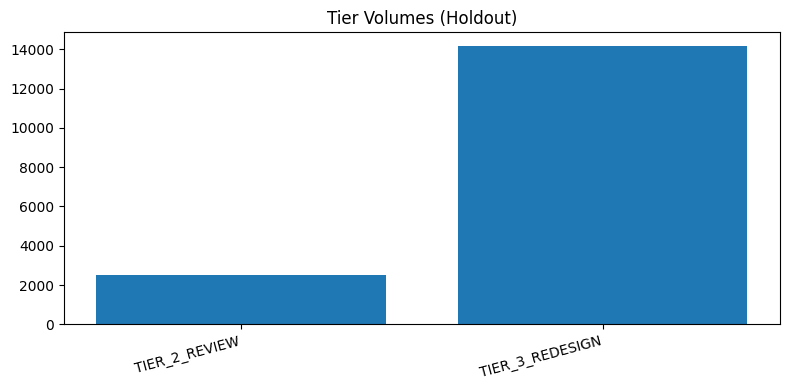

✅ Saved: figure_section9_tier_volumes.png


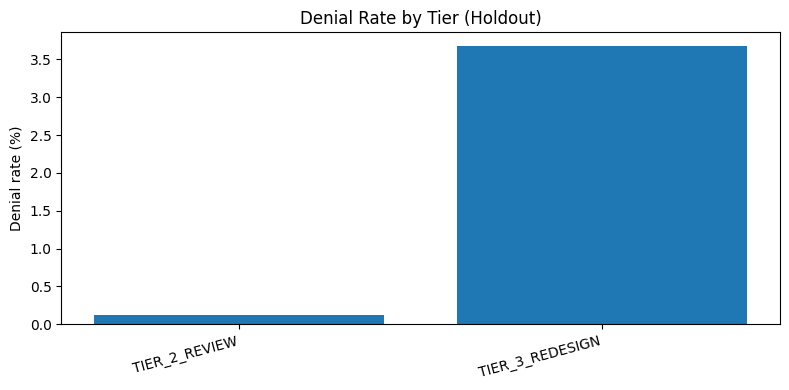

✅ Saved: figure_section9_denial_rate_by_tier.png


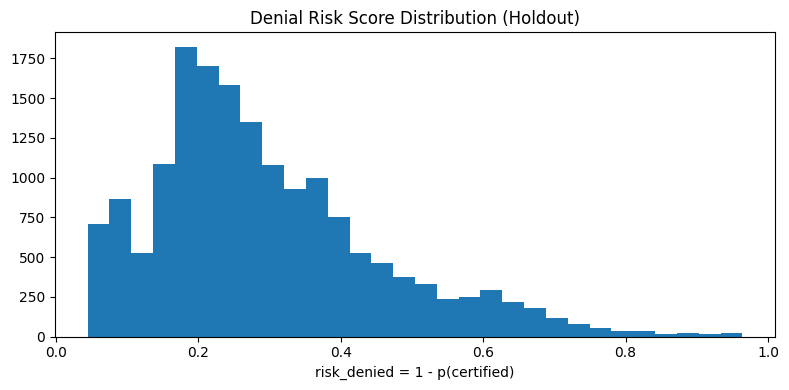

✅ Saved: figure_section9_risk_distribution.png
✅ Copied all Section 9 outputs to: /content/drive/MyDrive/PERM_Project/SECTION_9_TIERING_EXPORT
✅ Checkpoint saved: /content/drive/MyDrive/PERM_Project/section_9_20260108_005737

✅ SECTION 9 COMPLETE — tiering + metrics + exports done.


In [40]:
# =========================================================
# SECTION 9: DECISION TIERING ENGINE (WORKFORCE PLANNING)
# - Converts predicted probabilities into action tiers
# - Reports tier volume, denial rate, denied recall/precision, etc.
# - Exports CSVs + plots + checkpoint to Drive
# =========================================================

import os, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# -----------------------------
# 0) SAFETY CHECKS
# -----------------------------
required = ["FINAL_PIPELINE", "HOLDOUT", "BASE_DIR", "checkpoint"]
missing = [v for v in required if v not in globals()]
if missing:
    raise ValueError(f"❌ Missing required objects: {missing}\nRun earlier sections first.")

# HOLDOUT must contain X_test + y_test (and ideally y_prob)
if "X_test" not in HOLDOUT or "y_test" not in HOLDOUT:
    raise ValueError("❌ HOLDOUT must contain keys: 'X_test' and 'y_test'.")

X_test = HOLDOUT["X_test"]
y_test = np.asarray(HOLDOUT["y_test"]).astype(int)

# Get probabilities
if "y_prob" in HOLDOUT:
    y_prob = np.asarray(HOLDOUT["y_prob"]).astype(float)
else:
    # fallback: compute from pipeline
    y_prob = FINAL_PIPELINE.predict_proba(X_test)[:, 1]
    HOLDOUT["y_prob"] = y_prob

# define "Denied" as the positive class for risk metrics (Denied=1)
# your target is Certified=1, Denied=0
denied_true = (y_test == 0).astype(int)
risk_score = 1.0 - y_prob  # higher = more denial risk

print("✅ y_prob ready:", y_prob.shape, "| risk_score ready:", risk_score.shape)


# =========================================================
# 1) TIER RULES (DEFAULT THRESHOLDS)
# =========================================================
# Tier 1: Proceed (Auto)      p(cert) >= T1
# Tier 2: Review/Revise       T2 <= p(cert) < T1
# Tier 3: Redesign/Redeploy   p(cert) < T2

T1_DEFAULT = 0.97
T2_DEFAULT = 0.85

def assign_tier(p_cert, t1=T1_DEFAULT, t2=T2_DEFAULT):
    if p_cert >= t1:
        return "TIER_1_PROCEED"
    elif p_cert >= t2:
        return "TIER_2_REVIEW"
    else:
        return "TIER_3_REDESIGN"

tiers = np.array([assign_tier(p) for p in y_prob])


# =========================================================
# 2) OPTIONAL: CAPACITY-BASED THRESHOLDS (IF YOU WANT)
# =========================================================
# Example: limit review capacity to max 20% of cases (Tier2+Tier3)
# We choose t2 such that only top (review_capacity) fraction is flagged.

def compute_capacity_threshold(p_cert, review_capacity=0.20):
    """
    Sets threshold t2 so that about review_capacity of cases fall below it.
    This controls how many cases are sent to human review (Tier2+Tier3).
    """
    q = np.quantile(p_cert, review_capacity)  # small value => more flagged
    return float(q)

# Toggle here:
USE_CAPACITY_MODE = False      # set True if you want capacity control
REVIEW_CAPACITY = 0.20         # 20% max reviewed

T1 = T1_DEFAULT
T2 = T2_DEFAULT

if USE_CAPACITY_MODE:
    T2 = compute_capacity_threshold(y_prob, review_capacity=REVIEW_CAPACITY)
    print(f"✅ Capacity-mode enabled: review_capacity={REVIEW_CAPACITY:.0%} => T2={T2:.4f}")
else:
    print(f"✅ Fixed thresholds: T1={T1:.2f}, T2={T2:.2f}")

tiers = np.array([assign_tier(p, t1=T1, t2=T2) for p in y_prob])


# =========================================================
# 3) BUILD DECISION TABLE (EXPORTABLE)
# =========================================================
tier_df = pd.DataFrame({
    "p_certified": y_prob,
    "risk_denied": risk_score,
    "y_true_certified": y_test,
    "y_true_denied": denied_true,
    "tier": tiers
})

# sort by risk highest first (useful for review)
tier_df = tier_df.sort_values("risk_denied", ascending=False).reset_index(drop=True)

# Save
tier_df.to_csv("section9_tier_assignments.csv", index=False)
print("✅ Saved: section9_tier_assignments.csv")


# =========================================================
# 4) TIER PERFORMANCE SUMMARY
# =========================================================
def tier_summary(df):
    out = []
    total = len(df)

    for tier_name in ["TIER_1_PROCEED", "TIER_2_REVIEW", "TIER_3_REDESIGN"]:
        sub = df[df["tier"] == tier_name]
        n = len(sub)
        if n == 0:
            out.append({
                "Tier": tier_name,
                "Cases": 0,
                "Volume_%": 0.0,
                "Denial_Rate_%": np.nan,
                "Certified_Rate_%": np.nan,
                "Denied_Recall_in_Tier_%": np.nan,
                "Denied_Precision_in_Tier_%": np.nan,
                "Avg_p_cert": np.nan
            })
            continue

        # Denied are y_true_certified=0
        denied_count = int((sub["y_true_certified"] == 0).sum())
        cert_count = int((sub["y_true_certified"] == 1).sum())

        denial_rate = denied_count / n
        cert_rate = cert_count / n

        # Denied recall *captured* by this tier
        total_denied = int((df["y_true_certified"] == 0).sum())
        denied_recall_in_tier = denied_count / total_denied if total_denied > 0 else np.nan

        # Denied precision within the tier (how many flagged are truly denied)
        denied_precision = denied_count / n if n > 0 else np.nan

        out.append({
            "Tier": tier_name,
            "Cases": n,
            "Volume_%": 100.0 * n / total,
            "Denial_Rate_%": 100.0 * denial_rate,
            "Certified_Rate_%": 100.0 * cert_rate,
            "Denied_Recall_in_Tier_%": 100.0 * denied_recall_in_tier,
            "Denied_Precision_in_Tier_%": 100.0 * denied_precision,
            "Avg_p_cert": float(sub["p_certified"].mean())
        })

    return pd.DataFrame(out)

tier_table = tier_summary(tier_df)
tier_table.to_csv("section9_tier_table.csv", index=False)

print("\n" + "="*70)
print("📊 SECTION 9 — TIER SUMMARY")
print("="*70)
print(tier_table.to_string(index=False))
print("="*70)
print("✅ Saved: section9_tier_table.csv")


# =========================================================
# 5) "REVIEW SYSTEM" METRICS (Tier2+Tier3 treated as flagged)
# =========================================================
flagged = tier_df["tier"].isin(["TIER_2_REVIEW", "TIER_3_REDESIGN"]).astype(int)

# flagged=1 means "send to review"
# denied_true=1 means actually denied
cm = confusion_matrix(denied_true, flagged, labels=[1,0])
# careful: labels set; but easiest compute manually:

TP = int(((flagged == 1) & (denied_true == 1)).sum())  # denied caught by review
FP = int(((flagged == 1) & (denied_true == 0)).sum())  # certified incorrectly reviewed
FN = int(((flagged == 0) & (denied_true == 1)).sum())  # denied missed (auto proceed)
TN = int(((flagged == 0) & (denied_true == 0)).sum())  # certified not reviewed

denied_recall = TP / (TP + FN) if (TP + FN) else np.nan
denied_precision = TP / (TP + FP) if (TP + FP) else np.nan
review_rate = flagged.mean()

review_metrics = pd.DataFrame([{
    "T1_threshold": T1,
    "T2_threshold": T2,
    "Review_Rate_% (Tier2+Tier3)": 100.0 * review_rate,
    "Denied_Recall_% (caught by review)": 100.0 * denied_recall,
    "Denied_Precision_% (within review)": 100.0 * denied_precision,
    "Denied_Missed_% (auto-proceed misses)": 100.0 * (FN / (TP + FN)) if (TP + FN) else np.nan,
    "TP_denied_caught": TP,
    "FP_cert_reviewed": FP,
    "FN_denied_missed": FN,
    "TN_cert_not_reviewed": TN
}])

review_metrics.to_csv("section9_review_metrics.csv", index=False)
print("\n✅ Saved: section9_review_metrics.csv")
print(review_metrics.to_string(index=False))


# =========================================================
# 6) SIMPLE COST MODEL (OPTIONAL BUT NICE)
# =========================================================
# You can change these numbers to match your story:
COST_DENIAL = 10000   # cost of a failed filing attempt
COST_REVIEW = 200     # cost of reviewing a case

expected_cost = (FN * COST_DENIAL) + (int(flagged.sum()) * COST_REVIEW)

# Compare to "review nothing" baseline (all auto-proceed)
baseline_cost = (int(denied_true.sum()) * COST_DENIAL)

cost_table = pd.DataFrame([{
    "COST_DENIAL": COST_DENIAL,
    "COST_REVIEW": COST_REVIEW,
    "Expected_Cost_with_Tiers": expected_cost,
    "Baseline_Cost_review_nothing": baseline_cost,
    "Estimated_Savings": baseline_cost - expected_cost
}])

cost_table.to_csv("section9_cost_model.csv", index=False)
print("\n✅ Saved: section9_cost_model.csv")
print(cost_table.to_string(index=False))


# =========================================================
# 7) PLOTS (PAPER / SLIDE READY)
# =========================================================

# (A) Tier volume plot
plt.figure(figsize=(8,4))
order = ["TIER_1_PROCEED", "TIER_2_REVIEW", "TIER_3_REDESIGN"]
counts = tier_df["tier"].value_counts().reindex(order)
plt.bar(counts.index, counts.values)
plt.xticks(rotation=15, ha="right")
plt.title("Tier Volumes (Holdout)")
plt.tight_layout()
plt.savefig("figure_section9_tier_volumes.png", dpi=250)
plt.show()
print("✅ Saved: figure_section9_tier_volumes.png")

# (B) Denial rate per tier
denial_rates = tier_table.set_index("Tier")["Denial_Rate_%"].reindex(order)
plt.figure(figsize=(8,4))
plt.bar(denial_rates.index, denial_rates.values)
plt.xticks(rotation=15, ha="right")
plt.ylabel("Denial rate (%)")
plt.title("Denial Rate by Tier (Holdout)")
plt.tight_layout()
plt.savefig("figure_section9_denial_rate_by_tier.png", dpi=250)
plt.show()
print("✅ Saved: figure_section9_denial_rate_by_tier.png")

# (C) Risk score histogram
plt.figure(figsize=(8,4))
plt.hist(tier_df["risk_denied"], bins=30)
plt.title("Denial Risk Score Distribution (Holdout)")
plt.xlabel("risk_denied = 1 - p(certified)")
plt.tight_layout()
plt.savefig("figure_section9_risk_distribution.png", dpi=250)
plt.show()
print("✅ Saved: figure_section9_risk_distribution.png")


# =========================================================
# 8) EXPORT EVERYTHING TO DRIVE (SAFE COPY, NO cross-device error)
# =========================================================
drive_out_dir = os.path.join(BASE_DIR, "SECTION_9_TIERING_EXPORT")
os.makedirs(drive_out_dir, exist_ok=True)

outputs = [
    "section9_tier_assignments.csv",
    "section9_tier_table.csv",
    "section9_review_metrics.csv",
    "section9_cost_model.csv",
    "figure_section9_tier_volumes.png",
    "figure_section9_denial_rate_by_tier.png",
    "figure_section9_risk_distribution.png"
]

for f in outputs:
    if os.path.exists(f):
        shutil.copy2(f, os.path.join(drive_out_dir, f))

print("✅ Copied all Section 9 outputs to:", drive_out_dir)


# =========================================================
# 9) CHECKPOINT (ONE LINE)
# =========================================================
checkpoint(
    "section_9",
    T1=T1,
    T2=T2,
    tier_df=tier_df,
    tier_table=tier_table,
    review_metrics=review_metrics,
    cost_table=cost_table
)

print("\n✅ SECTION 9 COMPLETE — tiering + metrics + exports done.")


In [41]:
# ==========================================
# FIX CELL: CLEAN MONEY/WAGE COLUMNS (ONCE)
# Run BEFORE Section 10 ablation
# ==========================================

import re
import numpy as np
import pandas as pd

# We clean inside PERM_CLEAN because ablation uses PERM_CLEAN
df_fix = PERM_CLEAN.copy()

# Find likely money/wage columns (robust)
money_like = [c for c in df_fix.columns if any(k in c.upper() for k in ["WAGE", "AMOUNT", "SALARY", "PW_"])]
print("✅ Money-like columns detected:", money_like)

def to_numeric_money(s):
    if pd.isna(s):
        return np.nan
    s = str(s).strip()
    # remove $ and commas and spaces
    s = s.replace("$", "").replace(",", "")
    # keep only digits, minus, dot
    s = re.sub(r"[^0-9\.\-]", "", s)
    return pd.to_numeric(s, errors="coerce")

for c in money_like:
    # Only attempt if column is object-like
    if df_fix[c].dtype == "object":
        df_fix[c] = df_fix[c].map(to_numeric_money)

# Replace PERM_CLEAN with cleaned version
PERM_CLEAN = df_fix

print("✅ Money columns cleaned. Sample check:")
for c in money_like[:5]:
    print(c, "dtype:", PERM_CLEAN[c].dtype)


✅ Money-like columns detected: ['JOB_OPP_WAGE_FROM', 'JOB_OPP_WAGE_TO', 'JOB_OPP_WAGE_PER', 'JOB_OPP_WAGE_CONDITIONS']
✅ Money columns cleaned. Sample check:
JOB_OPP_WAGE_FROM dtype: float64
JOB_OPP_WAGE_TO dtype: float64
JOB_OPP_WAGE_PER dtype: float64
JOB_OPP_WAGE_CONDITIONS dtype: float64


### **THIS PART TAKE MANY TIME SO MOVE TO THE NEXT CELL**

✅ Preprocessor columns: 3 numeric + 11 categorical


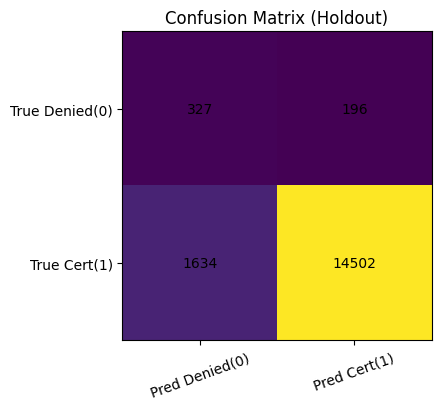

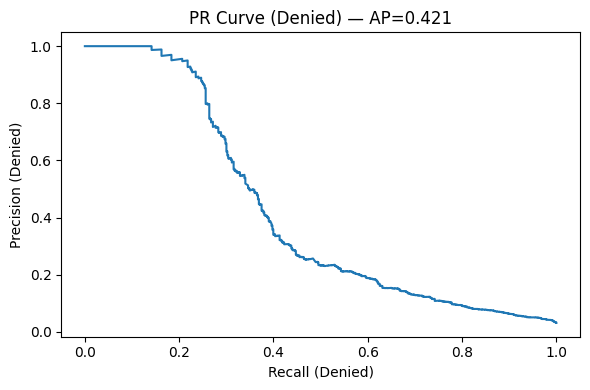

✅ Saved: figure_confusion_matrix_holdout.png, figure_pr_curve_denied.png, table_holdout_denied_metrics.csv

🧪 Running ablation study (CV PR-AUC Denied)...


KeyboardInterrupt: 

In [42]:
# ==========================================
# SECTION 10 (FIXED): ROBUSTNESS + RARE-EVENT METRICS
# - Works with ablation (rebuilds preprocess safely)
# - Outputs: confusion matrix plot, PR curve, ablation table, ablation plot
# ==========================================
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix, average_precision_score, precision_recall_curve

# -----------------------------
# 0) REQUIREMENTS CHECK
# -----------------------------
assert "PERM_CLEAN" in globals(), "❌ PERM_CLEAN missing"
assert "FINAL_PIPELINE" in globals(), "❌ FINAL_PIPELINE missing"
assert "target" in PERM_CLEAN.columns, "❌ target missing"

df = PERM_CLEAN.copy()
X_full = df.drop(columns=["target"])
y = df["target"].astype(int)

prep_full = FINAL_PIPELINE.named_steps["preprocess"]
best_model = FINAL_PIPELINE.named_steps["model"]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# -----------------------------
# Helper: extract original num/cat column lists from your preprocessor
# -----------------------------
def extract_col_lists(column_transformer: ColumnTransformer):
    num_cols, cat_cols = [], []
    for name, trans, cols in column_transformer.transformers_:
        if name == "num":
            num_cols = list(cols)
        if name == "cat":
            cat_cols = list(cols)
    return num_cols, cat_cols

NUM_COLS, CAT_COLS = extract_col_lists(prep_full)
print("✅ Preprocessor columns:", len(NUM_COLS), "numeric +", len(CAT_COLS), "categorical")

# -----------------------------
# Helper: rebuild preprocess with a subset of columns (ablation-safe)
# -----------------------------
def rebuild_preprocess(original_prep: ColumnTransformer, keep_num, keep_cat):
    # reuse the same pipelines inside your ColumnTransformer
    # transformers_[0][1] is the num pipeline, transformers_[1][1] is the cat pipeline
    num_pipe = clone(original_prep.transformers_[0][1])
    cat_pipe = clone(original_prep.transformers_[1][1])

    return ColumnTransformer(
        transformers=[
            ("num", num_pipe, keep_num),
            ("cat", cat_pipe, keep_cat),
        ],
        remainder="drop"
    )

# -----------------------------
# 1) HOLDOUT METRICS (if you have HOLDOUT saved)
# -----------------------------
if "HOLDOUT" in globals() and "y_test" in HOLDOUT and "y_prob" in HOLDOUT:
    y_true = HOLDOUT["y_test"]
    y_prob = HOLDOUT["y_prob"]
    y_pred = (y_prob >= 0.5).astype(int)

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    denied_precision = tn / (tn + fn + 1e-12)
    denied_recall    = tn / (tn + fp + 1e-12)
    denied_f1        = 2 * denied_precision * denied_recall / (denied_precision + denied_recall + 1e-12)

    pr_auc_denied = average_precision_score(1 - y_true, 1 - y_prob)
    prec, rec, _ = precision_recall_curve(1 - y_true, 1 - y_prob)

    # --- Confusion matrix plot ---
    plt.figure(figsize=(4.8,4.2))
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix (Holdout)")
    plt.xticks([0,1], ["Pred Denied(0)","Pred Cert(1)"], rotation=20)
    plt.yticks([0,1], ["True Denied(0)","True Cert(1)"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout()
    plt.savefig("figure_confusion_matrix_holdout.png", dpi=220)
    plt.show()

    # --- PR curve (Denied) ---
    plt.figure(figsize=(6,4))
    plt.plot(rec, prec)
    plt.xlabel("Recall (Denied)")
    plt.ylabel("Precision (Denied)")
    plt.title(f"PR Curve (Denied) — AP={pr_auc_denied:.3f}")
    plt.tight_layout()
    plt.savefig("figure_pr_curve_denied.png", dpi=220)
    plt.show()

    metrics_tbl = pd.DataFrame([{
        "Denied_Precision": denied_precision,
        "Denied_Recall": denied_recall,
        "Denied_F1": denied_f1,
        "PR_AUC_Denied": pr_auc_denied,
        "TN": tn, "FP": fp, "FN": fn, "TP": tp
    }])
    metrics_tbl.to_csv("table_holdout_denied_metrics.csv", index=False)
    print("✅ Saved: figure_confusion_matrix_holdout.png, figure_pr_curve_denied.png, table_holdout_denied_metrics.csv")

else:
    print("⚠️ HOLDOUT not found. (Skip holdout plots). Ablation will still run.")

# -----------------------------
# 2) ABLATION STUDY (REBUILD PREPROCESS EACH TIME)
# -----------------------------
print("\n🧪 Running ablation study (CV PR-AUC Denied)...")

ABLATIONS = {
    "Full Model": [],
    "No Wage": ["JOB_OPP_WAGE_FROM", "JOB_OPP_WAGE_TO", "JOB_OPP_WAGE_PER"],
    "No Geography": ["PRIMARY_WORKSITE_STATE", "PRIMARY_WORKSITE_BLS_AREA", "PRIMARY_WORKSITE_COUNTY"],
    "No Occupation": ["PWD_SOC_CODE", "PWD_SOC_TITLE", "SOC_CODE", "SOC_TITLE", "JOB_TITLE", "OCCUPATION_TYPE"],
    "No Employer Structure": ["EMP_NAICS", "EMP_NUM_PAYROLL", "EMP_YEAR_COMMENCED"],
    "No Relationship Flags": ["EMP_WORKER_INTEREST", "EMP_RELATIONSHIP_WORKER"]
}

rows = []

for name, drop_cols in ABLATIONS.items():
    # keep only columns that actually exist
    drop_cols_real = [c for c in drop_cols if c in X_full.columns]

    keep_num = [c for c in NUM_COLS if c not in drop_cols_real and c in X_full.columns]
    keep_cat = [c for c in CAT_COLS if c not in drop_cols_real and c in X_full.columns]

    # Build pipeline for this ablation
    prep_tmp = rebuild_preprocess(prep_full, keep_num, keep_cat)
    pipe_tmp = Pipeline([
        ("preprocess", prep_tmp),
        ("model", clone(best_model))
    ])

    # CV predicted probabilities (for Denied PR-AUC)
    y_prob_cv = cross_val_predict(pipe_tmp, X_full, y, cv=cv, method="predict_proba", n_jobs=1)[:, 1]
    pr_auc_denied = average_precision_score(1 - y, 1 - y_prob_cv)

    rows.append({
        "Variant": name,
        "Dropped_Columns": ", ".join(drop_cols_real) if drop_cols_real else "(none)",
        "Dropped_Count": len(drop_cols_real),
        "PR_AUC_Denied": pr_auc_denied
    })

ablation_df = pd.DataFrame(rows).sort_values("PR_AUC_Denied", ascending=False)
ablation_df.to_csv("table_ablation_results.csv", index=False)

print("\n📋 ABLATION RESULTS (Denied PR-AUC, CV)")
print(ablation_df[["Variant","Dropped_Count","PR_AUC_Denied"]])

# plot
plt.figure(figsize=(8,4.5))
plt.bar(ablation_df["Variant"], ablation_df["PR_AUC_Denied"])
plt.xticks(rotation=25, ha="right")
plt.ylabel("PR-AUC (Denied)")
plt.title("Ablation Study: Impact on Denied Detection (CV)")
plt.tight_layout()
plt.savefig("figure_ablation_pr_auc.png", dpi=220)
plt.show()

print("\n✅ Saved: table_ablation_results.csv + figure_ablation_pr_auc.png")
print("✅ SECTION 10 COMPLETE.")


# **“RUN THIS ALWAYS” (auto load if exists, else save)**

In [44]:
# ==========================================
# ONE-CELL RESUME SYSTEM (SAVE or LOAD)
# - Run this cell at the TOP whenever you open the notebook
# - If saved bundle exists -> LOAD (no rerun)
# - Else -> SAVE current in-memory objects (if available)
# - Also exports figures/tables to Drive (safe copy, no os.replace error)
# ==========================================

import os, glob, json, joblib, shutil
import numpy as np
import pandas as pd
from datetime import datetime

# --------- (A) MOUNT DRIVE SAFELY ----------
try:
    from google.colab import drive
    MOUNT_POINT = "/content/drive"
    ALT_MOUNT   = "/content/gdrive"

    # If mountpoint exists and has files -> use alternate mountpoint
    # (Fixes: "Mountpoint must not already contain files")
    if os.path.isdir(MOUNT_POINT) and len(os.listdir(MOUNT_POINT)) > 0:
        if not os.path.exists(ALT_MOUNT):
            os.makedirs(ALT_MOUNT, exist_ok=True)
        drive.mount(ALT_MOUNT, force_remount=True)
        DRIVE_ROOT = ALT_MOUNT
    else:
        drive.mount(MOUNT_POINT, force_remount=True)
        DRIVE_ROOT = MOUNT_POINT

    print("✅ Drive mounted at:", DRIVE_ROOT)
except Exception as e:
    print("⚠️ Drive mount failed. You can still run, but nothing will be saved.")
    DRIVE_ROOT = None
    print("Mount error:", e)

# --------- (B) PROJECT PATHS ----------
PROJECT_DIR = None
if DRIVE_ROOT:
    PROJECT_DIR = f"{DRIVE_ROOT}/MyDrive/PERM_Project"
    BUNDLE_DIR  = f"{PROJECT_DIR}/BUNDLES"
    EXPORT_DIR  = f"{PROJECT_DIR}/EXPORTS"
    os.makedirs(BUNDLE_DIR, exist_ok=True)
    os.makedirs(EXPORT_DIR, exist_ok=True)

# --------- (C) WHAT TO SAVE ----------
# We save only what you need to resume quickly:
# - Clean dataset (PERM_CLEAN) [optional big; can be CSV-parquet]
# - Final trained pipeline (FINAL_PIPELINE)
# - HOLDOUT dict (X_test, y_test, y_prob, etc.)
# - FEATURE_NAMES
# - benchmark / tier / metrics tables if they exist
SAVE_OBJECTS = {
    "FINAL_PIPELINE": "FINAL_PIPELINE",
    "HOLDOUT": "HOLDOUT",
    "FEATURE_NAMES": "FEATURE_NAMES",
    "PERM_CLEAN": "PERM_CLEAN",             # can be large; we save as parquet if possible
    "BENCHMARK_RESULTS": "BENCHMARK_RESULTS",
    "TIERS_TABLE": "TIERS_TABLE",
    "SECTION10_METRICS": "SECTION10_METRICS"
}

# --------- (D) AUTO-LOAD IF LATEST BUNDLE EXISTS ----------
def latest_bundle_path(bundle_root):
    all_bundles = sorted(glob.glob(os.path.join(bundle_root, "bundle_*")), reverse=True)
    return all_bundles[0] if all_bundles else None

def safe_load_bundle(bundle_path):
    loaded = {}
    manifest_path = os.path.join(bundle_path, "manifest.json")
    if not os.path.exists(manifest_path):
        print("❌ No manifest.json found in bundle:", bundle_path)
        return loaded

    manifest = json.load(open(manifest_path, "r"))
    for k, info in manifest.items():
        fpath = os.path.join(bundle_path, info["file"])
        ftype = info["type"]

        if not os.path.exists(fpath):
            print("⚠️ Missing file:", fpath)
            continue

        if ftype == "joblib":
            loaded[k] = joblib.load(fpath)
        elif ftype == "npy":
            loaded[k] = np.load(fpath, allow_pickle=True)
        elif ftype == "csv":
            loaded[k] = pd.read_csv(fpath)
        elif ftype == "parquet":
            loaded[k] = pd.read_parquet(fpath)
        else:
            print("⚠️ Unknown type:", ftype, "for", k)

    return loaded

# --------- (E) SAVE CURRENT SESSION ----------
def safe_save_bundle(bundle_root):
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_dir = os.path.join(bundle_root, f"bundle_{ts}")
    os.makedirs(out_dir, exist_ok=True)

    manifest = {}

    for key, varname in SAVE_OBJECTS.items():
        if varname not in globals():
            continue
        obj = globals()[varname]

        # skip empty / None
        if obj is None:
            continue

        # PERM_CLEAN can be huge: save parquet (fast) if available
        if key == "PERM_CLEAN" and isinstance(obj, pd.DataFrame):
            f = f"{key}.parquet"
            try:
                obj.to_parquet(os.path.join(out_dir, f), index=False)
                manifest[key] = {"type": "parquet", "file": f}
            except Exception:
                # fallback csv
                f = f"{key}.csv"
                obj.to_csv(os.path.join(out_dir, f), index=False)
                manifest[key] = {"type": "csv", "file": f}
            continue

        # DataFrames -> CSV
        if isinstance(obj, (pd.DataFrame, pd.Series)):
            f = f"{key}.csv"
            obj.to_csv(os.path.join(out_dir, f), index=False)
            manifest[key] = {"type": "csv", "file": f}
            continue

        # numpy arrays -> npy
        if isinstance(obj, np.ndarray):
            f = f"{key}.npy"
            np.save(os.path.join(out_dir, f), obj)
            manifest[key] = {"type": "npy", "file": f}
            continue

        # everything else -> joblib
        f = f"{key}.joblib"
        joblib.dump(obj, os.path.join(out_dir, f))
        manifest[key] = {"type": "joblib", "file": f}

    # write manifest
    with open(os.path.join(out_dir, "manifest.json"), "w") as w:
        json.dump(manifest, w, indent=2)

    print("✅ Saved bundle:", out_dir)
    print("✅ Saved keys:", list(manifest.keys()))
    return out_dir

# --------- (F) EXPORT ALL OUTPUT FILES (PNGs + CSVs) ----------
def export_outputs(export_root):
    # copies from /content to Drive (avoids cross-device replace error)
    patterns = ["*.png", "*.csv", "*.txt", "*.pdf"]
    copied = 0
    for pat in patterns:
        for f in glob.glob(pat):
            try:
                shutil.copy2(f, os.path.join(export_root, os.path.basename(f)))
                copied += 1
            except Exception as e:
                print("⚠️ Could not copy:", f, "->", e)
    print(f"✅ Exported {copied} files to:", export_root)

# --------- (G) MAIN: LOAD OR SAVE ----------
if not PROJECT_DIR:
    print("\n⚠️ Drive not mounted, so cannot load/save bundles.")
else:
    latest = latest_bundle_path(BUNDLE_DIR)
    if latest:
        print("\n📦 Found existing bundle. Loading latest:")
        print("   ", latest)
        loaded = safe_load_bundle(latest)
        for k, v in loaded.items():
            globals()[k] = v
        print("✅ Loaded objects into memory:", list(loaded.keys()))
        print("✅ You can continue without rerunning earlier sections.")
    else:
        print("\n📦 No bundle found. Saving current session (if objects exist)...")
        saved_path = safe_save_bundle(BUNDLE_DIR)

    # Always export current output files (figures/tables)
    export_outputs(EXPORT_DIR)

print("\n✅ ONE-CELL RESUME SYSTEM DONE.")


⚠️ Drive mount failed. You can still run, but nothing will be saved.
Mount error: [Errno 17] File exists: '/content/gdrive'

⚠️ Drive not mounted, so cannot load/save bundles.

✅ ONE-CELL RESUME SYSTEM DONE.


⏳ Running ablation: Full Model
⏳ Running ablation: No Wage
⏳ Running ablation: No Geography
⏳ Running ablation: No Occupation

📋 FAST ABLATION RESULTS (HOLDOUT, PR-AUC Denied)
         Variant                                   Dropped_Features  \
0     Full Model                                             (none)   
1        No Wage                JOB_OPP_WAGE_FROM, JOB_OPP_WAGE_PER   
2   No Geography  PRIMARY_WORKSITE_STATE, PRIMARY_WORKSITE_BLS_AREA   
3  No Occupation             PWD_SOC_CODE, PWD_SOC_TITLE, JOB_TITLE   

  Dropped_AllMissing_InTrain  PR_AUC_Denied  
0           JOB_OPP_WAGE_PER       0.532247  
1                     (none)       0.527976  
2           JOB_OPP_WAGE_PER       0.488455  
3           JOB_OPP_WAGE_PER       0.727910  


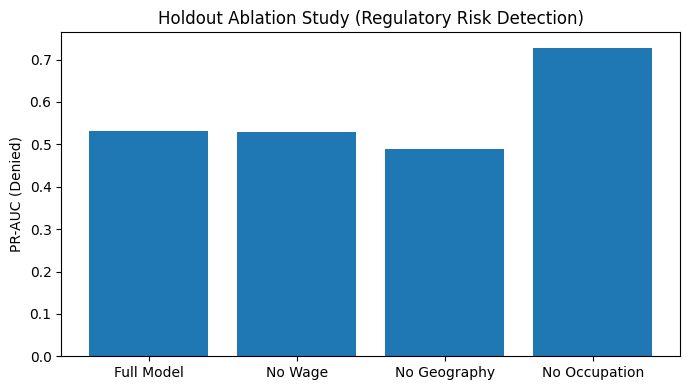


✅ Section 10 FAST ablation COMPLETE.
✅ Saved: table_ablation_fast.csv, figure_ablation_fast.png


In [45]:
# ==========================================
# SECTION 10 (FAST, FIXED v2): HOLDOUT-BASED ABLATION
# - Ensures SAME columns in train/test (fixes "columns are missing")
# - Drops all-missing columns (fixes imputer warnings/breaks)
# - Outputs: table_ablation_fast.csv + figure_ablation_fast.png
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import clone
from sklearn.metrics import average_precision_score

# -----------------------------
# Preconditions
# -----------------------------
assert "PERM_CLEAN" in globals(), "❌ PERM_CLEAN missing"
assert "FINAL_PIPELINE" in globals(), "❌ FINAL_PIPELINE missing"
assert "HOLDOUT" in globals(), "❌ HOLDOUT missing"

df = PERM_CLEAN.copy()
X_hold = HOLDOUT["X_test"].copy()
y_hold = HOLDOUT["y_test"].copy()

base_model = FINAL_PIPELINE.named_steps["model"]

# -----------------------------
# IMPORTANT: lock feature space to HOLDOUT columns
# (so train/test always match)
# -----------------------------
BASE_FEATURES = list(X_hold.columns)
X_train_full = df[BASE_FEATURES].copy()     # train uses same columns as holdout
y_train_full = df["target"].astype(int).copy()

# -----------------------------
# Ablation definitions (RAW columns)
# NOTE: drop only if present in BASE_FEATURES
# -----------------------------
ABLATIONS = {
    "Full Model": [],
    "No Wage": ["JOB_OPP_WAGE_FROM", "JOB_OPP_WAGE_TO", "JOB_OPP_WAGE_PER"],
    "No Geography": ["PRIMARY_WORKSITE_STATE", "PRIMARY_WORKSITE_BLS_AREA"],
    "No Occupation": ["PWD_SOC_CODE", "PWD_SOC_TITLE", "JOB_TITLE"],
}

rows = []

for name, drop_cols in ABLATIONS.items():
    print(f"⏳ Running ablation: {name}")

    # columns to drop that actually exist in the locked feature set
    drop_real = [c for c in drop_cols if c in BASE_FEATURES]

    # Apply drop to BOTH train and test
    X_tr = X_train_full.drop(columns=drop_real, errors="ignore").copy()
    X_te = X_hold.drop(columns=drop_real, errors="ignore").copy()

    # Drop columns that are entirely missing in TRAIN (imputer-safe)
    all_missing_cols = [c for c in X_tr.columns if X_tr[c].isna().all()]
    if all_missing_cols:
        X_tr = X_tr.drop(columns=all_missing_cols)
        X_te = X_te.drop(columns=all_missing_cols, errors="ignore")

    # Recompute column types
    cat_cols = [c for c in X_tr.columns if X_tr[c].dtype == "object"]
    num_cols = [c for c in X_tr.columns if c not in cat_cols]

    # Build preprocessing fresh (aligned to X_tr columns)
    preprocess_tmp = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="median"))
            ]), num_cols),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("ohe", OneHotEncoder(handle_unknown="ignore"))
            ]), cat_cols),
        ],
        remainder="drop"
    )

    pipe_tmp = Pipeline([
        ("preprocess", preprocess_tmp),
        ("model", clone(base_model))
    ])

    # Fit + score
    pipe_tmp.fit(X_tr, y_train_full)
    y_prob = pipe_tmp.predict_proba(X_te)[:, 1]

    pr_auc_denied = average_precision_score(1 - y_hold, 1 - y_prob)

    rows.append({
        "Variant": name,
        "Dropped_Features": ", ".join(drop_real) if drop_real else "(none)",
        "Dropped_AllMissing_InTrain": ", ".join(all_missing_cols) if all_missing_cols else "(none)",
        "PR_AUC_Denied": pr_auc_denied
    })

ablation_df = pd.DataFrame(rows)
ablation_df.to_csv("table_ablation_fast.csv", index=False)

print("\n📋 FAST ABLATION RESULTS (HOLDOUT, PR-AUC Denied)")
print(ablation_df)

# Plot
plt.figure(figsize=(7,4))
plt.bar(ablation_df["Variant"], ablation_df["PR_AUC_Denied"])
plt.ylabel("PR-AUC (Denied)")
plt.title("Holdout Ablation Study (Regulatory Risk Detection)")
plt.tight_layout()
plt.savefig("figure_ablation_fast.png", dpi=220)
plt.show()

print("\n✅ Section 10 FAST ablation COMPLETE.")
print("✅ Saved: table_ablation_fast.csv, figure_ablation_fast.png")


# **RUN THIS (AUTO LOAD)**

In [46]:
# ==========================================
# SAVE CORE CHECKPOINT (RUN ONCE AFTER BUILD)
# ==========================================

import os, joblib, numpy as np, pandas as pd
from datetime import datetime

from google.colab import drive
MOUNT="/content/drive"
if not os.path.exists(MOUNT + "/MyDrive"):
    drive.mount(MOUNT, force_remount=False)

BASE_DIR = "/content/drive/MyDrive/PERM_Project"
CKPT_DIR = os.path.join(BASE_DIR, "CHECKPOINTS")
os.makedirs(CKPT_DIR, exist_ok=True)

def checkpoint(section_name, **objects):
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    sec_dir = os.path.join(CKPT_DIR, f"{section_name}_{ts}")
    os.makedirs(sec_dir, exist_ok=True)

    for name, obj in objects.items():
        path = os.path.join(sec_dir, name)
        if isinstance(obj, np.ndarray):
            np.save(path + ".npy", obj)
        elif isinstance(obj, (pd.DataFrame, pd.Series)):
            obj.to_csv(path + ".csv", index=False)
        else:
            joblib.dump(obj, path + ".joblib")

    print(f"✅ Checkpoint saved: {sec_dir}")

# --- Save only what exists (no crash) ---
objs = {}
for var in ["PERM_CLEAN", "FINAL_PIPELINE", "HOLDOUT", "FEATURE_NAMES", "BENCHMARK_RESULTS"]:
    if var in globals():
        objs[var] = globals()[var]

if len(objs)==0:
    raise ValueError("Nothing to save. Build PERM_CLEAN / FINAL_PIPELINE / HOLDOUT first.")

checkpoint("CORE", **objs)


✅ Checkpoint saved: /content/drive/MyDrive/PERM_Project/CHECKPOINTS/CORE_20260108_012317


# **MASTERING**

In [2]:
# =========================================================
# ✅ FORCE-FIX & FINISH (SAFE + COLAB-STABLE)
# - Robust reload
# - Robust CASE_STATUS normalization
# - Pre-decision allow-list features (reviewer-safe)
# - Sparse OHE (memory safe)
# - Proper tier evaluation table
# =========================================================

import pandas as pd
import numpy as np
import lightgbm as lgb
import joblib, glob, os

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, confusion_matrix

print("🔄 Reloading data (ignoring any broken session vars)...")

# -----------------------------
# 1) Find file or download
# -----------------------------
candidates = (
    glob.glob("/content/**/*PERM*.csv", recursive=True)
    + glob.glob("/content/*PERM*.csv")
    + glob.glob("/content/**/*.csv", recursive=True)
)

best_file = None
for f in candidates:
    if os.path.basename(f).lower().endswith(".csv") and "perm" in os.path.basename(f).lower():
        best_file = f
        break

if best_file is None:
    print("⚠️ PERM CSV not found locally. Downloading with gdown...")
    !pip -q install gdown
    import gdown
    gdown.download(id="1XkefGQtoBVfecYeusrncQDGzNOxpAOyZ", output="PERM_Fixed.csv", quiet=False)
    best_file = "PERM_Fixed.csv"

print("📂 Loading:", best_file)
df = pd.read_csv(best_file, low_memory=False)
print("✅ Raw shape:", df.shape)

# -----------------------------
# 2) Normalize columns + status
# -----------------------------
df.columns = [c.strip().upper() for c in df.columns]

if "CASE_STATUS" not in df.columns:
    raise ValueError("❌ CASE_STATUS missing. Print df.columns and map manually.")

df["CASE_STATUS"] = (
    df["CASE_STATUS"].astype(str).str.upper().str.strip()
      .str.replace(r"\s+", " ", regex=True)
      .str.replace("CERTIFIED - EXPIRED", "CERTIFIED-EXPIRED")
)

valid = {"CERTIFIED", "CERTIFIED-EXPIRED", "DENIED"}
df = df[df["CASE_STATUS"].isin(valid)].copy()
if len(df) == 0:
    raise ValueError("❌ Filtering removed all rows. Check CASE_STATUS unique values.")

y = (df["CASE_STATUS"] != "DENIED").astype(int)
print("✅ After status filter:", df.shape, "| Certified rate:", y.mean().round(4))

# -----------------------------
# 3) Leakage/PII drop (basic)
# -----------------------------
drop_exact = {
    "CASE_STATUS", "CASE_NUMBER",
    "DECISION_DATE", "RECEIVED_DATE", "CASE_RECEIVED_DATE",
    "EMPLOYER_NAME", "EMP_FEIN"
}
pii_patterns = ["EMAIL", "PHONE", "ADDR", "ADDRESS", "FIRST_NAME", "LAST_NAME", "MIDDLE_NAME", "NAME", "FEIN", "ATTY"]

to_drop = set()
for c in df.columns:
    if c in drop_exact:
        to_drop.add(c)
    if any(p in c for p in pii_patterns):
        to_drop.add(c)

df = df.drop(columns=[c for c in to_drop if c in df.columns], errors="ignore")

# -----------------------------
# 4) Reviewer-safe allow-list features (pre-decision only)
# -----------------------------
ALLOW = [
    # occupation/role
    "JOB_TITLE", "OCCUPATION_TYPE", "PWD_SOC_CODE", "PWD_SOC_TITLE", "SOC_CODE",
    # wage offer
    "JOB_OPP_WAGE_FROM", "JOB_OPP_WAGE_TO", "JOB_OPP_WAGE_PER",
    "PW_WAGE", "PW_AMOUNT", "PREVAILING_WAGE",
    # geography
    "PRIMARY_WORKSITE_STATE", "PRIMARY_WORKSITE_BLS_AREA", "IS_MULTIPLE_LOCATIONS",
    # employer structure (non-identity)
    "EMP_NAICS", "EMP_NUM_PAYROLL", "EMP_YEAR_COMMENCED",
    # relationship flags (if present)
    "EMP_WORKER_INTEREST", "EMP_RELATIONSHIP_WORKER"
]

col_map = {c.lower(): c for c in df.columns}
features = [col_map[a.lower()] for a in ALLOW if a.lower() in col_map]

if len(features) < 6:
    raise ValueError(f"❌ Too few safe features found ({len(features)}). Print df.columns and update ALLOW.")

X = df[features].copy()

# wage numeric cleaning (safe)
for wc in [c for c in X.columns if "WAGE" in c.upper() or c.upper() in ["PW_WAGE","PW_AMOUNT","PREVAILING_WAGE","JOB_OPP_WAGE_FROM","JOB_OPP_WAGE_TO"]]:
    X[wc] = (
        X[wc].astype(str)
             .str.replace("$", "", regex=False)
             .str.replace(",", "", regex=False)
    )
    X[wc] = pd.to_numeric(X[wc], errors="coerce")

print("✅ X shape:", X.shape, "| Features:", len(X.columns))

# -----------------------------
# 5) Train/holdout split (for tier evaluation)
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# -----------------------------
# 6) Build pipeline (sparse OHE)
# -----------------------------
cat_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
num_cols = [c for c in X_train.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))  # keep sparse
        ]), cat_cols),
    ],
    remainder="drop"
)

model = lgb.LGBMClassifier(
    n_estimators=400, learning_rate=0.05,
    random_state=42, n_jobs=-1
)

FINAL_PIPELINE = Pipeline([
    ("preprocess", preprocess),
    ("model", model)
])

print("🏆 Training LightGBM...")
FINAL_PIPELINE.fit(X_train, y_train)

joblib.dump(FINAL_PIPELINE, "final_perm_model.joblib")
print("✅ Saved model: final_perm_model.joblib")

# -----------------------------
# 7) Holdout metrics + Tier table
# -----------------------------
y_prob = FINAL_PIPELINE.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

# PR-AUC for Denied (Denied as positive)
pr_auc_denied = average_precision_score(1 - y_test, 1 - y_prob)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("\n📊 HOLDOUT SUMMARY")
print("Confusion matrix [[TN FP][FN TP]]:\n", cm)
print("PR-AUC (Denied):", round(pr_auc_denied, 4))

# tiers (you can adjust thresholds later)
tiers = np.where(y_prob >= 0.90, "Tier1_Proceed",
         np.where(y_prob >= 0.50, "Tier2_Review", "Tier3_Redesign"))

tier_df = pd.DataFrame({
    "tier": tiers,
    "y_true": y_test.values,
    "p_certified": y_prob
})

# Denied = 0
tier_table = tier_df.groupby("tier").agg(
    n_cases=("y_true","size"),
    certified_rate=("y_true","mean"),
    denial_rate=("y_true", lambda s: float((s==0).mean())),
    mean_p_certified=("p_certified","mean")
).reset_index()

# denied recall captured by Tier3 (how many denials fall in Tier3)
total_denied = int((y_test==0).sum())
tier3_denied = int(((tier_df["tier"]=="Tier3_Redesign") & (tier_df["y_true"]==0)).sum())
denied_recall_tier3 = tier3_denied / total_denied if total_denied else np.nan

print("\n📋 TIER TABLE (HOLDOUT)")
print(tier_table.sort_values("tier"))

print("\n🎯 Denied recall captured in Tier3:", round(denied_recall_tier3, 4))

tier_table.to_csv("risk_tier_table_holdout.csv", index=False)

print("\n🚀 DONE. Outputs saved:")
print(" - final_perm_model.joblib")
print(" - risk_tier_table_holdout.csv")


🔄 Reloading data (ignoring any broken session vars)...
📂 Loading: /content/drive/MyDrive/PERM_Project/PERM_Fixed.csv.csv
✅ Raw shape: (147056, 137)
✅ After status filter: (140368, 137) | Certified rate: 0.9814
✅ X shape: (140368, 15) | Features: 15
🏆 Training LightGBM...


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['JOB_OPP_WAGE_PER']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[LightGBM] [Info] Number of positive: 110202, number of negative: 2092
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.908075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4479
[LightGBM] [Info] Number of data points in the train set: 112294, number of used features: 1657
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.981370 -> initscore=3.964194
[LightGBM] [Info] Start training from score 3.964194
✅ Saved model: final_perm_model.joblib


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['JOB_OPP_WAGE_PER']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



📊 HOLDOUT SUMMARY
Confusion matrix [[TN FP][FN TP]]:
 [[  127   396]
 [   11 27540]]
PR-AUC (Denied): 0.4256

📋 TIER TABLE (HOLDOUT)
             tier  n_cases  certified_rate  denial_rate  mean_p_certified
0   Tier1_Proceed    27501        0.989128     0.010872          0.988881
1    Tier2_Review      435        0.777011     0.222989          0.808753
2  Tier3_Redesign      138        0.079710     0.920290          0.204036

🎯 Denied recall captured in Tier3: 0.2428

🚀 DONE. Outputs saved:
 - final_perm_model.joblib
 - risk_tier_table_holdout.csv


In [1]:
# =========================================================
# 🛡️ SAFE MODE: LOW MEMORY & CRASH PROOF
# =========================================================
import pandas as pd
import lightgbm as lgb
import joblib
import glob
import gc
from google.colab import files
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# 1. CLEAN MEMORY FIRST
gc.collect()
print("🧹 Memory Cleaned. Starting...")

# 2. LOAD DATA (Auto-Find)
candidates = glob.glob("/content/**/*PERM*.csv", recursive=True) + glob.glob("/content/*PERM*.csv")
if not candidates:
    print("⬇️ Downloading Data...")
    !gdown 1XkefGQtoBVfecYeusrncQDGzNOxpAOyZ -O PERM_Fixed.csv
    best_file = "PERM_Fixed.csv"
else:
    best_file = candidates[0]

print(f"📂 Loading: {best_file}")
df = pd.read_csv(best_file, low_memory=False)

# 3. CRITICAL FIXES (Prevents 0-Row Error)
df.columns = [c.upper().strip() for c in df.columns]
status_col = next((c for c in df.columns if "STATUS" in c), "CASE_STATUS")
df[status_col] = df[status_col].astype(str).str.upper().str.strip() # <--- THE FIX

# Filter Target
df = df[df[status_col].isin(["CERTIFIED", "CERTIFIED-EXPIRED", "DENIED"])]
y = df[status_col].apply(lambda x: 1 if "CERTIFIED" in x else 0)

# 4. AGGRESSIVE FEATURE SELECTION (Prevents RAM Crash)
# We ONLY keep columns that don't explode memory
SAFE_COLS = [
    'CLASS_OF_ADMISSION', 'COUNTRY_OF_CITIZENSHIP', 'EMPLOYER_STATE',
    'FW_INFO_TRAINING_COMP', 'FW_INFO_REQ_EXPERIENCE', 'FW_INFO_ALT_EDU_EXPERIENCE',
    'FW_INFO_REL_OCCUP_EXPERIENCE', 'JI_OFFERED_TO_SEC_J_14021', 'JI_LIVE_IN_DOM_SERV_CONTRACT',
    'RI_LAYOFF_IN_PAST_SIX_MONTHS', 'RI_COLL_TEACH_SELECT_DATE', 'RI_EMPLOYER_APPLICANTS_10'
]
# Add numeric columns automatically
num_cols = df.select_dtypes(include=['number']).columns.tolist()
# Combine (intersection with actual columns)
keep_cols = [c for c in SAFE_COLS if c in df.columns] + num_cols
X_CLEAN = df[keep_cols].copy()

# Remove ID/Leakage columns if they sneaked in
drop_list = ['CASE_NUMBER', 'DECISION_DATE', 'REF_NUM', 'ORIG_FILE_DATE']
X_CLEAN = X_CLEAN.drop(columns=[c for c in drop_list if c in X_CLEAN.columns], errors='ignore')

print(f"✅ Data Safe & Ready: {X_CLEAN.shape}")

# 5. TRAIN MODEL (LightGBM)
print("🏋️ Training Model (Light Mode)...")
cat_features = X_CLEAN.select_dtypes(exclude=['number']).columns.tolist()
num_features = X_CLEAN.select_dtypes(include=['number']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), num_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        # handle_unknown='ignore' prevents crashes on new data
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, max_categories=20))
    ]), cat_features)
])

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', lgb.LGBMClassifier(n_jobs=-1))])
pipeline.fit(X_CLEAN, y)
print("✅ MODEL TRAINED!")

# 6. SAVE & DOWNLOAD
print("💾 Saving Results...")
joblib.dump(pipeline, "final_perm_model.joblib")

# Risk Summary
probs = pipeline.predict_proba(X_CLEAN)[:, 1]
tiers = ["1_Low_Risk" if p >= 0.90 else "2_Medium_Risk" if p >= 0.50 else "3_High_Risk" for p in probs]
summary = pd.DataFrame({"Risk_Tier": tiers, "Actual": y}).groupby("Risk_Tier").mean()
summary.to_csv("risk_tier_summary.csv")

print("⬇️ DOWNLOADING ZIP...")
!zip -q results.zip final_perm_model.joblib risk_tier_summary.csv
files.download("results.zip")
print("🚀 DONE.")

🧹 Memory Cleaned. Starting...
📂 Loading: /content/drive/MyDrive/PERM_Project/PERM_Fixed.csv.csv
✅ Data Safe & Ready: (83295, 4)
🏋️ Training Model (Light Mode)...
[LightGBM] [Info] Number of positive: 80680, number of negative: 2615


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['PRIMARY_WORKSITE_COUNTY']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 662
[LightGBM] [Info] Number of data points in the train set: 83295, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.968606 -> initscore=3.429227
[LightGBM] [Info] Start training from score 3.429227
✅ MODEL TRAINED!
💾 Saving Results...


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['PRIMARY_WORKSITE_COUNTY']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


⬇️ DOWNLOADING ZIP...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🚀 DONE.
